In [88]:
import matplotlib.cm
import scipy.stats.mstats
import statsmodels.stats.stattools
%config InlineBackend.figure_formats = ['png']

import multiprocessing
import pandas as pd
from data import rciw_mjhd, rmad_hd, collect_energy_data_paths, get_project_and_benchmark_from_consumption_path, \
    get_normalized_mj_from_file, rmad_hd, custom_mquantiles_cimh_hd
from collections import defaultdict
import numpy as np
import matplotlib.pyplot as plt
import pickle
import seaborn as sns
import scipy.stats as stats
from pathlib import Path



In [89]:
ITERATIONS = 30
MAX_SAMPLES_PER_ITERATION = 300
SAMPLE_STEP = 25
SAMPLES_PER_ITERATION_RANGE = range(SAMPLE_STEP, MAX_SAMPLES_PER_ITERATION + 1, SAMPLE_STEP)

THRESHOLDS = [0.5, 1, 3, 5, 10]


In [90]:

benchmarks = defaultdict(list)

for path in collect_energy_data_paths():
    (proj, bench) = get_project_and_benchmark_from_consumption_path(path)
    # if proj == 'tracing':
    #     continue
    benchmarks[proj + '/' + bench.replace("\\", "/")].extend(get_normalized_mj_from_file(path).tolist())
# benchmarks


In [91]:
import json

def get_num_iters(path):
    data = json.load(path.open())
    return data['iters'][0]
    
iters = defaultdict(list)

for path in collect_energy_data_paths():
    (proj, bench) = get_project_and_benchmark_from_consumption_path(path)
    # if proj == 'tracing':
    #     continue
    iters[proj + '/' + bench.replace("\\", "/")].append(get_num_iters(path))
max_samples = max(map(len, iters.values()))
too_little_samples = [key for key, values in iters.items() if len(values) != max_samples]
iters = pd.DataFrame({k: v for k, v in iters.items() if k not in too_little_samples}).T
iters[iters.max(axis=1) < 50].max(axis=1).sort_values()

rust-base64/encode_large_input/encode_display/31457280                                                      1.0
rust-base64/decode_large_input/decode_stream/31457280                                                       1.0
rust-base64/decode_large_input/decode_reuse_buf/31457280                                                    1.0
rust-base64/decode_large_input/decode/31457280                                                              1.0
rust-base64/encode_large_input/encode_reuse_buf_stream/31457280                                             1.0
                                                                                                           ... 
curve25519-dalek/Multiscalar multiplications/Variable-time variable-base multiscalar multiplication/256    42.0
itertools/comb/comb c4                                                                                     47.0
itertools/comb/comb c3                                                                                  

In [92]:

max_samples = max(map(len, benchmarks.values()))
too_little_samples = [key for key, values in benchmarks.items() if len(values) != max_samples]
consumption = pd.DataFrame({k: v for k, v in benchmarks.items() if k not in too_little_samples})


## Normality

In [93]:
# for bench in consumption.columns:
int((np.array([scipy.stats.normaltest(consumption[bench]).pvalue for bench in consumption.columns]) < 0.05).mean() * len(consumption.columns)), len(consumption.columns)

(861, 868)

## Initial variability

In [94]:
# sns.stripplot(consumption.T[(consumption.T.max(axis='columns') - consumption.T.min(axis='columns')) > 50][:200], size=1, jitter=False)
# consumption.columns[(consumption.max(axis='rows') - consumption.min(axis='rows')) > 50]
large_consumption_difference = consumption.T[
    (consumption.T.max(axis='columns') - consumption.T.min(axis='columns')) / consumption.T.min(axis='columns')  > 0.5]


Text(0.5, 0, 'Total number of samples over time')

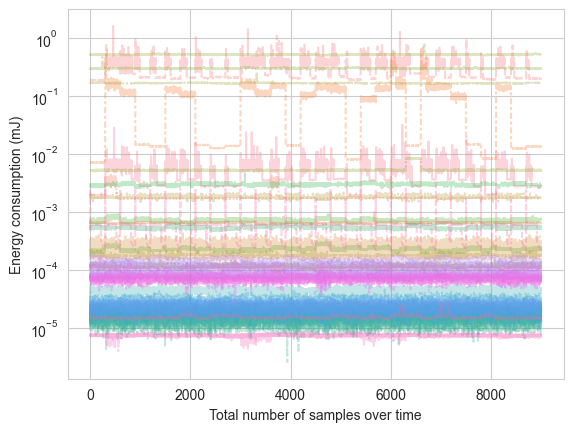

In [95]:
sns.lineplot(large_consumption_difference.T, markers=False, estimator=None, legend=False, alpha=0.3)
plt.yscale('log')
plt.ylabel("Energy consumption (mJ)")
plt.xlabel("Total number of samples over time")
# large_consumption_difference

597 226 45 868


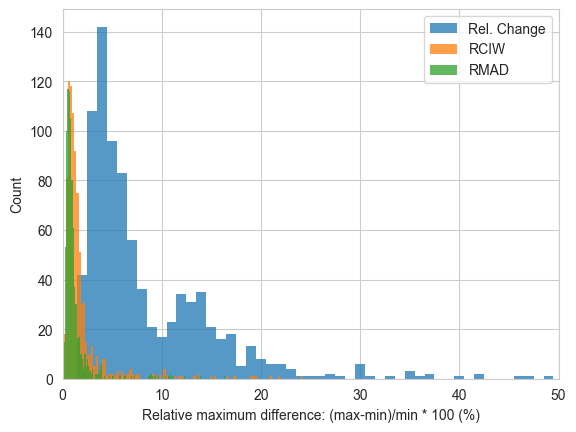

In [96]:
first_samples = consumption.take(range(0, 9000, 300))
# sns.histplot(first_samples.apply(lambda x: rciw_mjhd(x, 0.05), axis=0) * 100)
# plt.xlim([0, 25])
# for bench in first_samples.columns:
#     # print(bench, scipy.stats.wilcoxon(first_samples[bench]))
#     # print(first_samples[bench])
#     sns.sca
#     # break
# fig, axs  = plt.subplots(1,1)
# axs = axs.flatten()
# sns.scatterplot()
data = first_samples.reset_index().drop(columns=['index'])
# mins = data.min(axis=0)
# print(mins)
max_diff = (data.max(axis=0) - data.min(axis=0)) / data.min(axis=0)
# for i, col in enumerate(first_samples.columns):
#     sns.barplot(data, id="ghello")
# sns.stripplot(data,ax=axs )
sns.histplot(max_diff * 100, binwidth=1)
sns.histplot(data.apply(lambda x: rciw_mjhd(x, 0.05), axis=0) * 100)
sns.histplot(data.apply(lambda x: rmad_hd(x) * 100, axis=0))
# sns.histplot(data.apply(rmad_hd, axis=0) * 100)
# # data
# plt.legend(["RCIW", "RMAD"])
low = max_diff.loc[max_diff < 0.1].count()
high = max_diff.loc[max_diff > 0.25].count()
med = max_diff.count() - low - high

print(low, med, high, max_diff.count())
plt.xlim([0, 50])
# plt.yscale('log')
plt.xlabel("Relative maximum difference: (max-min)/min * 100 (%)")
plt.legend(["Rel. Change", "RCIW", "RMAD"])

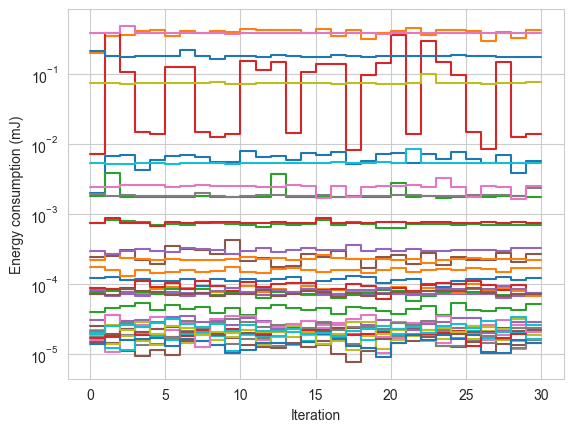

In [97]:
from itertools import repeat
from itertools import chain

first_samples = consumption.take(range(0, 9000, 300))
data = first_samples.reset_index().drop(columns=['index'])
# & (data.max(axis=0) < 0.0001)
for bench in data.T[((data.max(axis=0) - data.min(axis=0)) / data.min(axis=0) > 0.3) ].T.columns:
    plt.plot(list(chain.from_iterable(zip(range(0,30), range(1,31)))),list(chain.from_iterable(zip(data[bench], data[bench]))), )
    # plt.plot(range(0,30), data[bench])
# data.T
plt.ylabel("Energy consumption (mJ)")
plt.xlabel("Iteration")
plt.yscale('log')

## Inter-Intra iteration variability

In [98]:
# Inter-iteration variability
# Group into iterations
iteration_groups = consumption.groupby(by=lambda idx: int(idx // 300))
intra_iteration_rciw = iteration_groups.agg(func=lambda df: rciw_mjhd(df, 0.05)).apply(func = lambda df: pd.Series(np.ma.getdata(scipy.stats.mstats.hdmedian(df, axis=1))[()]))

# sns.histplot()
# sns.histplot(inter_iteration_rciw)
# inter_iteration_rciw

In [99]:
median_per_iteration = iteration_groups.apply(func = lambda df: pd.Series(np.ma.getdata(scipy.stats.mstats.hdmedian(df, axis=0))))
# type(median_per_iteration)
inter_iteration_rciw = median_per_iteration.agg(func=lambda df: rciw_mjhd(df, 0.05))

In [100]:
intra_iteration_rciw.values.flatten()

array([0.00091424, 0.00079982, 0.00074025, 0.00090516, 0.00172262,
       0.00195298, 0.00196611, 0.03215806, 0.0251069 , 0.00185529,
       0.00170153, 0.00175088, 0.00569704, 0.00522815, 0.0054469 ,
       0.00196414, 0.0021556 , 0.00063767, 0.00358984, 0.00358066,
       0.0035295 , 0.00348907, 0.00212336, 0.00206982, 0.00219337,
       0.00214778, 0.00297657, 0.0018394 , 0.00068744, 0.01189517,
       0.0010759 , 0.00202405, 0.00159265, 0.00039741, 0.00044524,
       0.00092268, 0.00202982, 0.0019829 , 0.00203256, 0.00154222,
       0.0017647 , 0.00199592, 0.00056533, 0.00075093, 0.00283962,
       0.00273282, 0.00293603, 0.0024984 , 0.00259368, 0.00144715,
       0.00152282, 0.00098539, 0.0010057 , 0.00118554, 0.00237732,
       0.00202344, 0.0025265 , 0.00111984, 0.00062937, 0.00103032,
       0.00127326, 0.00141647, 0.00106131, 0.00116274, 0.0025187 ,
       0.00236708, 0.00231324, 0.0025584 , 0.00172236, 0.0008472 ,
       0.00274281, 0.00153057, 0.0047331 , 0.00044142, 0.00045

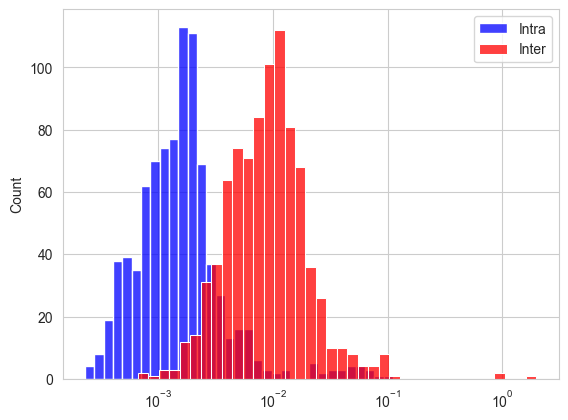

(SignificanceResult(statistic=0.3235836618631093, pvalue=1.318095947431715e-22),
 WilcoxonResult(statistic=20458.0, pvalue=1.3341519861523834e-114))

In [101]:
sns.histplot(intra_iteration_rciw.values.flatten(), log_scale=True, color='blue')
sns.histplot(inter_iteration_rciw, color='red')
plt.legend(['Intra', 'Inter'])
plt.show()
scipy.stats.spearmanr(intra_iteration_rciw.values.flatten(), inter_iteration_rciw), scipy.stats.wilcoxon(intra_iteration_rciw.values.flatten(), inter_iteration_rciw)

In [102]:

# sns.scatterplot(y=intra_iteration_rciw.values, x=range(868))
# sns.scatterplot(y=inter_iteration_rciw.values, x=range(868))
# plt.yscale('log')

In [103]:
# consumption # consumption in mJ per benchmark execution
print(f"Maximum energy consumption for a single execution within 100ms is {consumption.max().max():.5}mJ.")
print(
    f"This translates to at most {consumption.max().max() / 0.1 / 1000:.3}W. This is {'not ' if consumption.max().max() / 0.1 / 1000 > 11.65 else ''}within the limit of a single core of the tested CPU.")

Maximum energy consumption for a single execution within 100ms is 903.08mJ.
This translates to at most 9.03W. This is within the limit of a single core of the tested CPU.


## Number of Instructions

In [104]:

actual_instr = pd.read_csv("instructions.csv", sep=";", names=('project', 'file', 'id', 'instructions'))
actual_instr['id'] = actual_instr['project'] + '/' + actual_instr['id'].map(lambda s: s.strip())
actual_instr = actual_instr.drop(columns=['project', 'file']).set_index('id')
actual_instr = actual_instr.loc[actual_instr['instructions'] > 0]
actual_instr = actual_instr.loc[actual_instr['instructions'] < 4.2e9 / 10]
actual_instr


instructions
id                                                              
chrono/bench_datetime_parse_from_rfc2822/bench_...         31592
chrono/bench_datetime_parse_from_rfc3339/bench_...         28060
chrono/bench_datetime_from_str/bench_datetime_f...         39755
chrono/bench_datetime_to_rfc2822/bench_datetime...          8585
chrono/bench_datetime_to_rfc3339/bench_datetime...         11162
...                                                          ...
bytecount/counts/naive_32/900                             114728
bytecount/counts/hyper/900                                 18431
bytecount/counts/naive/1000                               127428
bytecount/counts/naive_32/1000                            127428
bytecount/counts/hyper/1000                                20418

[838 rows x 1 columns]

In [105]:
instruction_consumption = actual_instr.join(consumption.T, how='inner')

Text(0.5, 0, 'Executed instruction count')

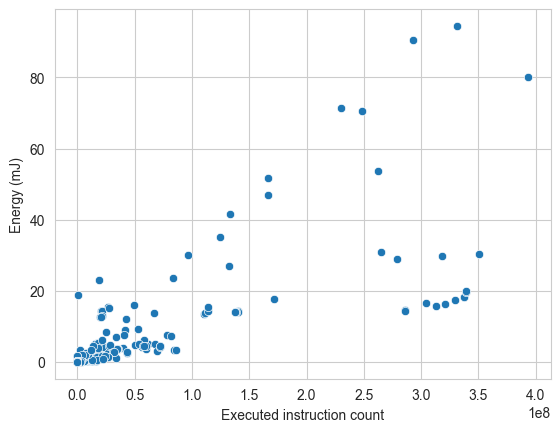

In [106]:
sns.scatterplot(x=instruction_consumption['instructions'],
                y=stats.mstats.hdmedian(instruction_consumption.drop(columns=["instructions"]), axis=1))
plt.ylabel("Energy (mJ)")
plt.xlabel("Executed instruction count")


Text(0.5, 0, 'Number of executed instructions')

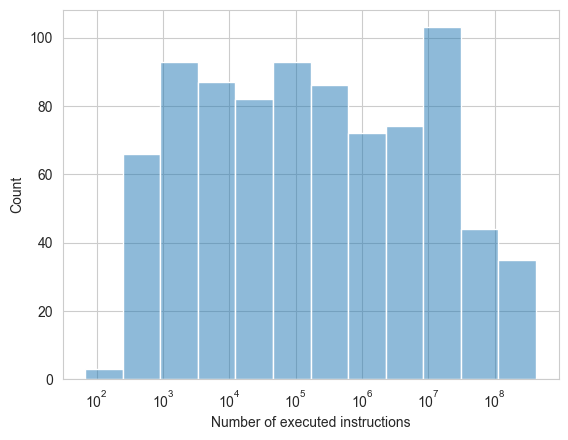

In [107]:
sns.histplot(actual_instr, log_scale=(10, False), legend=False)
plt.xlabel("Number of executed instructions")

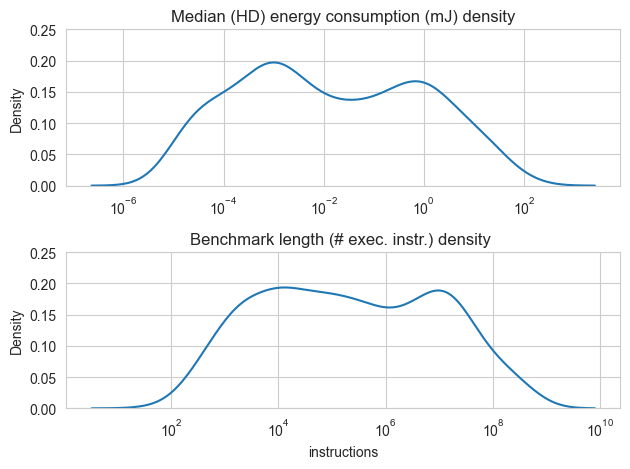

[[1.         0.78125386]
 [0.78125386 1.        ]]
0.0
0.9571273016356053


In [108]:
f, ax = plt.subplots(2)
# sns.histplot(consumption.to_numpy().flatten(), bins=30, log_scale=(10, False), ax=ax[0], legend=False, stat='density')
# sns.histplot(actual_instr, bins=30, ax=ax[1], log_scale=(10, False), legend=False, stat='density')

sns.kdeplot(np.ma.getdata(stats.mstats.hdmedian(instruction_consumption.drop(columns=["instructions"]), axis=1), ),
            log_scale=(10, False), ax=ax[0], legend=False)
ax[0].set_ylim([0, 0.25])
ax[0].set_title("Median (HD) energy consumption (mJ) density")
sns.kdeplot(instruction_consumption['instructions'], ax=ax[1], log_scale=(10, False), legend=False, )
ax[1].set_title("Benchmark length (# exec. instr.) density ")
ax[1].set_ylim([0, 0.25])
f.tight_layout()
plt.show()

meds = np.ma.getdata(stats.mstats.hdmedian(instruction_consumption.drop(columns=["instructions"]), axis=1), )
print(np.corrcoef(meds, instruction_consumption["instructions"]))
spearmanr = stats.spearmanr(meds, instruction_consumption["instructions"])
print(spearmanr.pvalue)
print(spearmanr.statistic)

This Spearman Correlation statistic of 0.95 shows a high correlation between the two Ordinal variables. 
The p-value of 0.0 is lower than 0.05 and we reject the null hypothesis that the data is independent from each other. Which it isn't since it is based on the same code. This shows however that median energy and benchmark length have a correlation.

## Calculate Stability
Define a multithreadable task that can calculate a certain statistic over a multi-index range of up to iterations and up to samples.

We calculate both RCIW and RMAD, which are both defined in [data.py](./data.py).


In [109]:
from typing import Callable, Tuple
from multiprocessing.pool import ThreadPool


def pooled_task(stat_fn: Callable[[np.ndarray], float], bench_id: str, values: np.ndarray, iterations: int,
                samples: int) -> Tuple[Tuple[str, int, int], float]:
    # indices = [i % 300 < samples for i in range(300 * iterations)]
    # creates a Basic Indexing view into values that has shape (30, -1) where -1 can be up to 300
    try:
        return ((bench_id, iterations, samples), stat_fn(np.array(values[:iterations, :samples].flatten())))
    except IndexError:
        return ((bench_id, iterations, samples), np.NaN)


pool = ThreadPool(processes=14)

In [110]:
from scipy.stats.mstats import mquantiles_cimj


def calc_rciw(data):
    # print(len(data))
    return rciw_mjhd(data, 0.05)
    # diff = mquantiles_cimj(data, prob=[0.5])


try:
    rciw_data = pickle.load(open('rciw_95.pickle', 'rb'))
except FileNotFoundError:
    args = []
    for bench in consumption.columns:
        arranged = np.array(consumption[bench]).reshape(ITERATIONS, -1)
        for iterations in range(ITERATIONS):
            for samples in SAMPLES_PER_ITERATION_RANGE:
                args.append([calc_rciw, bench, arranged, iterations + 1, samples])

    rciw_data = {k: v for k, v in pool.starmap(pooled_task, args)}
    pickle.dump(rciw_data, open('rciw_95.pickle', 'wb'))

In [111]:
def med_hj(data):
    return float(np.ma.getdata(scipy.stats.mstats.hdmedian(data, axis=0)))


try:
    median_data = pickle.load(open('medians.pickle', 'rb'))
except FileNotFoundError:
    args = []
    for bench in consumption.columns:
        arranged = np.array(consumption[bench]).reshape(ITERATIONS, -1)
        for iterations in range(ITERATIONS):
            for samples in SAMPLES_PER_ITERATION_RANGE:
                args.append([med_hj, bench, arranged, iterations + 1, samples])

    median_data = {k: v for k, v in pool.starmap(pooled_task, args)}
    pickle.dump(median_data, open('medians.pickle', 'wb'))

In [112]:
try:
    rmad_data = pickle.load(open('rmad.pickle', 'rb'))
except FileNotFoundError:
    args = []
    for bench in consumption.columns:
        arranged = np.array(consumption[bench]).reshape(ITERATIONS, -1)
        for iterations in range(ITERATIONS):
            for samples in SAMPLES_PER_ITERATION_RANGE:
                args.append([rmad_hd, bench, arranged, iterations + 1, samples])

    rmad_data = {k: v for k, v in pool.starmap(pooled_task, args)}
    pickle.dump(rmad_data, open('rmad.pickle', 'wb'))

In [113]:
def ciw(data, cl=0.05):
    alpha=min(cl, 1-cl)
    ci = custom_mquantiles_cimh_hd(data, prob=[0.5], alpha=alpha)
    ciw = (ci[1] - ci[0])
    return ciw[0]

try:
    ciw_data = pickle.load(open('ciw.pickle', 'rb'))
except FileNotFoundError:
    args = []
    for bench in consumption.columns:
        arranged = np.array(consumption[bench]).reshape(ITERATIONS, -1)
        for iterations in range(ITERATIONS):
            for samples in SAMPLES_PER_ITERATION_RANGE:
                args.append([ciw, bench, arranged, iterations + 1, samples])

    ciw_data = {k: v for k, v in pool.starmap(pooled_task, args)}
    pickle.dump(rmad_data, open('ciw.pickle', 'wb'))

In [114]:
# experiment_iters = rciw.join(np.array(iters).min(axis=1).rename("executions"), on='bench',)
# experiment_iters.sort_index(level=['bench', 'iterations', 'samples'], inplace=True)
# sns.scatterplot(experiment_iters.loc[:, 5:, 100:], x="executions", y="rciw", )
# plt.xscale('log')


In [115]:
# rciw = pd.DataFrame(rciw_data)

rciw = pd.DataFrame(rciw_data.values(),
                    index=pd.MultiIndex.from_tuples(rciw_data.keys(), names=["bench", "iterations", "samples"]),
                    columns=['rciw'])
rmad = pd.DataFrame(rmad_data.values(),
                    index=pd.MultiIndex.from_tuples(rmad_data.keys(), names=["bench", "iterations", "samples"]),
                    columns=['rmad'])
medians = pd.DataFrame(median_data.values(),
                    index=pd.MultiIndex.from_tuples(median_data.keys(), names=["bench", "iterations", "samples"]),
                    columns=['median'])

ciw = pd.DataFrame(ciw_data.values(),
                   index=pd.MultiIndex.from_tuples(ciw_data.keys(), names=["bench", "iterations", "samples"]),
                   columns=["ciw"])

stabilities = rmad.join(rciw)


(array([2.68239e+05, 4.54800e+03, 4.29600e+03, 6.99000e+02, 3.08000e+02,
        4.40000e+01, 3.40000e+01, 3.00000e+01, 2.80000e+01, 1.30000e+01,
        7.00000e+00, 4.00000e+00, 8.00000e+00, 4.00000e+00, 5.00000e+00,
        2.00000e+00, 3.00000e+00, 1.00000e+00, 2.00000e+00, 5.00000e+00]),
 array([2.75828792e-04, 4.26894678e-02, 8.51031068e-02, 1.27516746e-01,
        1.69930385e-01, 2.12344024e-01, 2.54757663e-01, 2.97171302e-01,
        3.39584941e-01, 3.81998580e-01, 4.24412219e-01, 4.66825858e-01,
        5.09239497e-01, 5.51653136e-01, 5.94066775e-01, 6.36480414e-01,
        6.78894053e-01, 7.21307692e-01, 7.63721331e-01, 8.06134970e-01,
        8.48548609e-01]),
 <BarContainer object of 20 artists>)

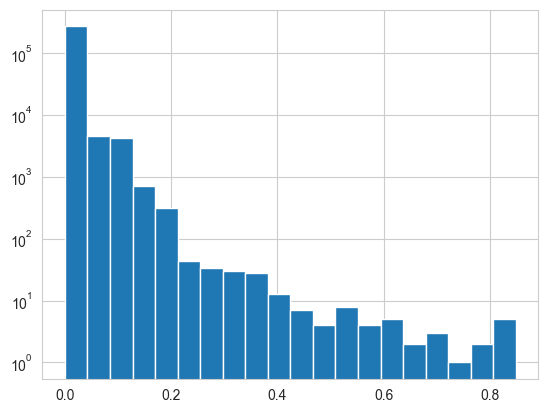

In [116]:
# sns.histplot(ciw)
plt.hist(ciw, bins=20, log=True)

# ciw# plt.xsca

<Axes: ylabel='Count'>

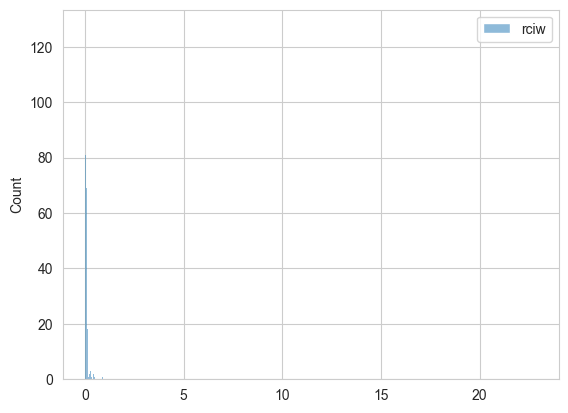

In [117]:
sns.histplot(rciw.loc[:, 30, 300] * 100)

/tmp/ipykernel_6765/2992391274.py:4: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.histplot(stabilities.loc[:, 2, 25]['rciw'] * 100, legend=True, ax=ax, palette='tab10_r')
/tmp/ipykernel_6765/2992391274.py:5: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.histplot(stabilities.loc[:, 1, 25]['rciw'] * 100, legend=True, ax=ax, palette='Set1')


(0.0, 5.0)

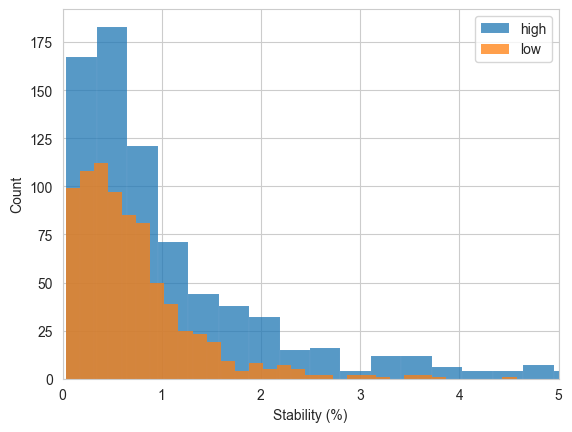

In [118]:
fig, ax = plt.subplots(1)
# log_scale=(10, False)
# sns.kdeplot(stabilities['rciw'] * 100, ax=ax, legend=True)
sns.histplot(stabilities.loc[:, 2, 25]['rciw'] * 100, legend=True, ax=ax, palette='tab10_r')
sns.histplot(stabilities.loc[:, 1, 25]['rciw'] * 100, legend=True, ax=ax, palette='Set1')
# sns.kdeplot(stabilities, x='rciw', ax=ax, log_scale=(10, False), legend=True)
plt.xlabel("Stability (%)")
ax.legend(['high', 'low'])
plt.xlim([0, 5])
# ax.legend(['rmad', 'rciw', 'rmad30', 'rciw30', 'rmad1', 'rciw1'])


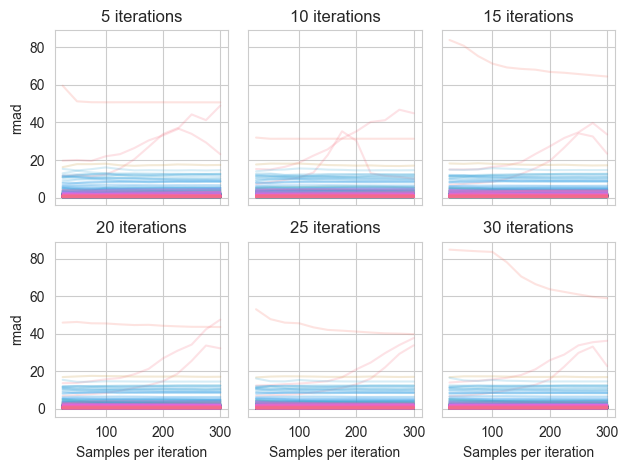

In [119]:
from statsmodels.stats.stattools import medcouple
# iters = range(1,31)
iters = range(5, 31, 5)
fig, axs = plt.subplots(2, 3, sharex=True, sharey=True)
# local = rciw.loc[(slice(None), i, slice(None))]

for idx, s in enumerate(iters):
    ax = axs.flatten()[idx]
    local = rmad.loc[(slice(None), s, slice(None))]
    local['rmad'] *= 100
    # data = medians.loc[(slice(None), s, slice(None))] / medians.loc[(slice(None), s, 300)] #slice(None))].apply(lambda df: df.groupby('bench').median())
    sns.lineplot(local, x='samples', y='rmad', 
                   units='bench', hue='bench',
                 legend=False, ax=ax,
                   estimator=None, alpha=0.2
                   )
#     print(medcouple(medians.loc[(slice(None), s, slice(None))], axis=0))
    ax.set_title(f"{s} iterations")
    ax.set_xlabel("Samples per iteration")
    # ax.set_ylim([0, 20])
plt.tight_layout()
# plt.yscale('log')

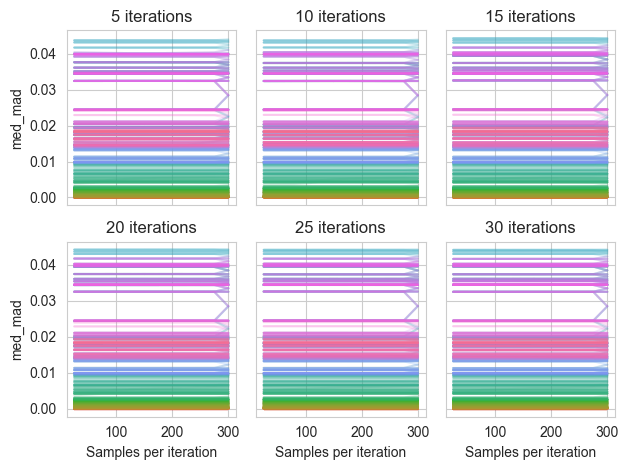

In [120]:
from statsmodels.stats.stattools import medcouple
# iters = range(1,31)
iters = range(5, 31, 5)
fig, axs = plt.subplots(2, 3, sharex=True, sharey=True)
# local = rciw.loc[(slice(None), i, slice(None))]

## MAD of medians
for idx, s in enumerate(iters):
    ax = axs.flatten()[idx]
    local = medians.loc[(slice(None), s, slice(None))]
    local['med_mad'] = local['median'].expanding(1).apply(scipy.stats.median_abs_deviation)
    # data = medians.loc[(slice(None), s, slice(None))] / medians.loc[(slice(None), s, 300)] #slice(None))].apply(lambda df: df.groupby('bench').median())
    sns.lineplot(local, x='samples', y='med_mad', 
                   units='bench', hue='bench',
                 legend=False, ax=ax,
                   estimator=None, alpha=0.2
                   )
#     print(medcouple(medians.loc[(slice(None), s, slice(None))], axis=0))
    ax.set_title(f"{s} iterations")
    ax.set_xlabel("Samples per iteration")
    # ax.set_ylim([0, 20])
plt.tight_layout()
# plt.yscale('log')

median    relmed
bench                                       samples                    
parity-common/iter/single key from iterator 50       0.006205  0.990851
                                            75       0.006164  0.984344
                                            100      0.006152  0.982443
                                            125      0.006132  0.979211
                                            150      0.006101  0.974223
...                                                       ...       ...
tracing/event/scoped_recording              300      0.000609  0.987097
bytecount/counts/naive_32/0                 225      0.000015  0.993653
                                            250      0.000015  0.993487
                                            275      0.000015  0.993348
                                            300      0.000015  0.993154

[186 rows x 2 columns]

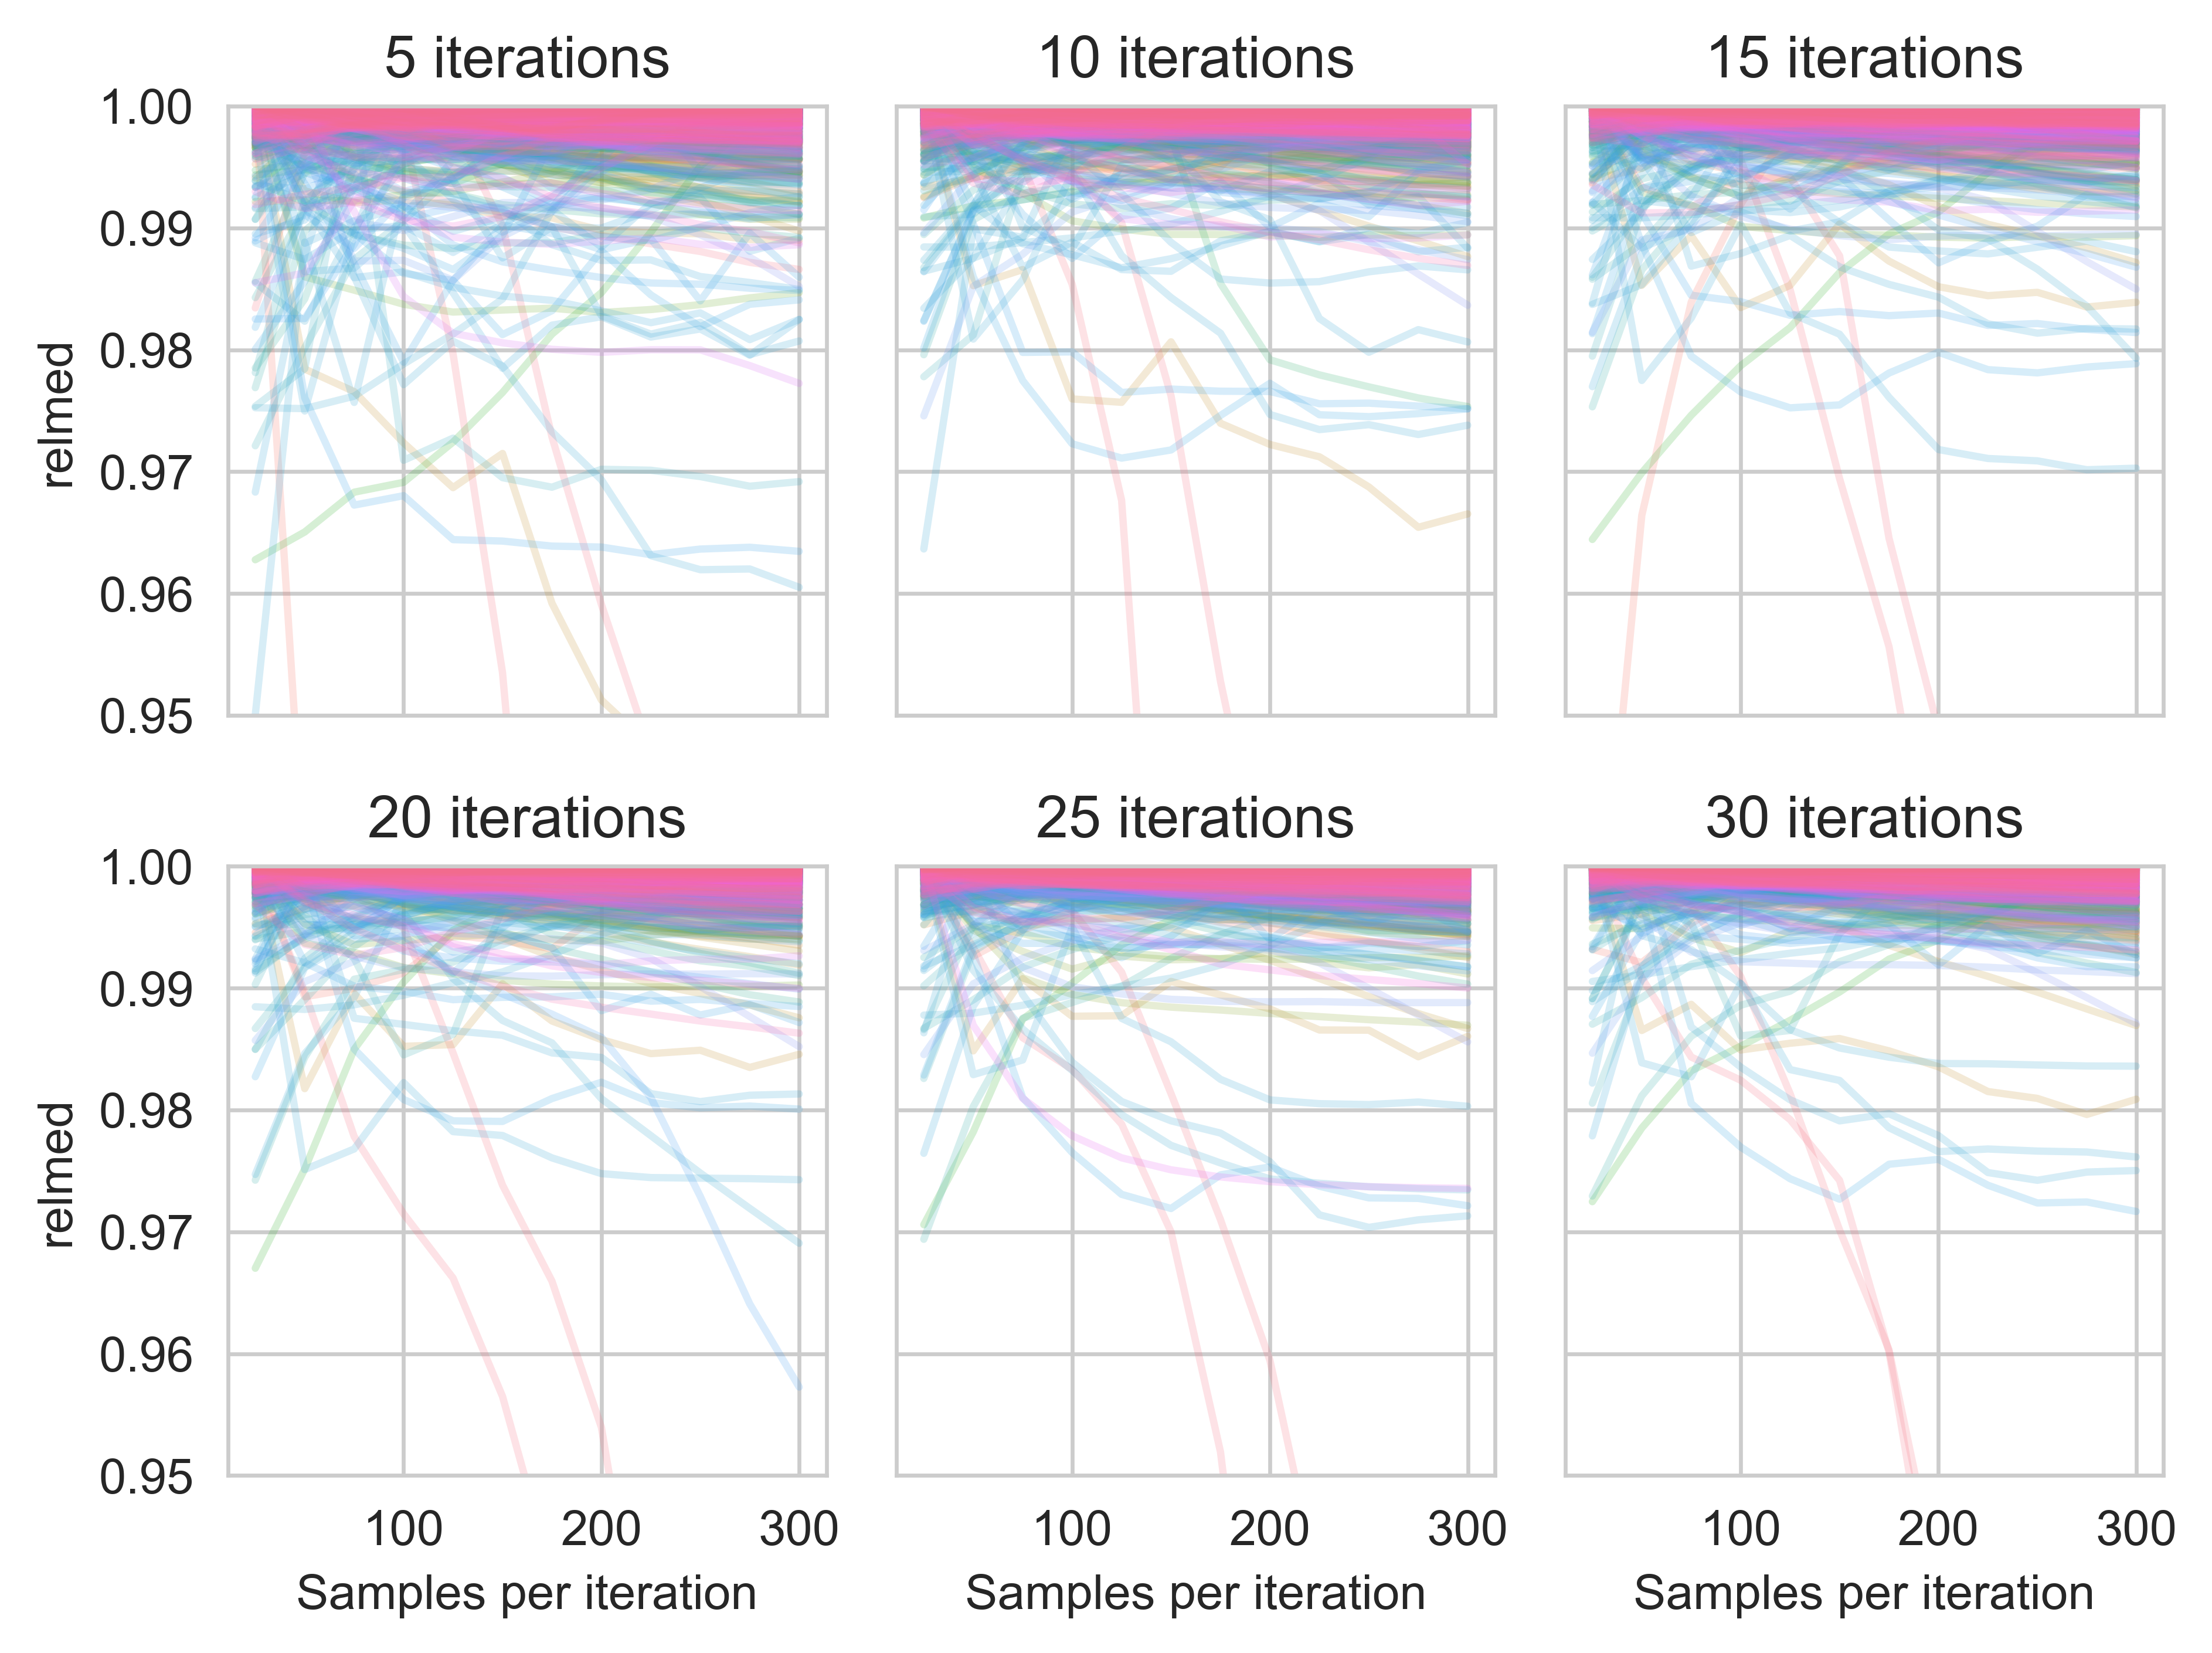

In [121]:
from statsmodels.stats.stattools import medcouple
# iters = range(1,31)
iters = range(5, 31, 5)
fig, axs = plt.subplots(2, 3, sharex=True, sharey=True, dpi=600)
# local = rciw.loc[(slice(None), i, slice(None))]

for idx, s in enumerate(iters):
    ax = axs.flatten()[idx]
    data = medians.loc[(slice(None), s, slice(None))]
    data['relmed'] = data['median'] / data['median'].groupby('bench').max()
    sns.lineplot(data, x='samples', y='relmed', 
                   units='bench', hue='bench',
                 legend=False, ax=ax,
                   estimator=None, alpha=0.2
                   )
#     print(medcouple(medians.loc[(slice(None), s, slice(None))], axis=0))
    ax.set_title(f"{s} iterations")
    ax.set_xlabel("Samples per iteration")
    ax.set_ylim([0.95, 1.0])
plt.tight_layout()
# plt.yscale('log')
# medians.loc[(slice(None), 30, slice(None))].apply(lambda df: df.groupby('bench').median())
# data.loc[((data['median'] / data['median'].groupby(['bench']).max()) < 0.99)]
data.loc[data['relmed'] < 0.994]

## Classify stability 
For both stability measures, classify for each threshold what proportion is stable.

In [122]:
def ratio_stable(data, x, y, subplot_value):
    return ((data * 100) < subplot_value).loc[slice(None), x, y].value_counts(normalize=True).get(True, 0)


In [123]:
classified = dict()
for idx, threshold in enumerate(THRESHOLDS):

    values = []
    for iteration in range(ITERATIONS):
        for samples in SAMPLES_PER_ITERATION_RANGE:
            ratio = ratio_stable(rciw, iteration + 1, samples, threshold)
            values.append(ratio)
    reshaped = np.array(values).reshape(ITERATIONS, len(SAMPLES_PER_ITERATION_RANGE))
    classified[threshold] = reshaped

In [124]:
classified_rmad = dict()
for idx, threshold in enumerate(THRESHOLDS):

    values = []
    for iteration in range(ITERATIONS):
        for samples in SAMPLES_PER_ITERATION_RANGE:
            ratio = ratio_stable(rmad, iteration + 1, samples, threshold)
            values.append(ratio)
    reshaped = np.array(values).reshape(ITERATIONS, len(SAMPLES_PER_ITERATION_RANGE))
    classified_rmad[threshold] = reshaped

In [125]:
instruction_rciw = rciw.join(actual_instr, on='bench', how='inner')
instruction_rciw['rciw'] = instruction_rciw['rciw'] * 100

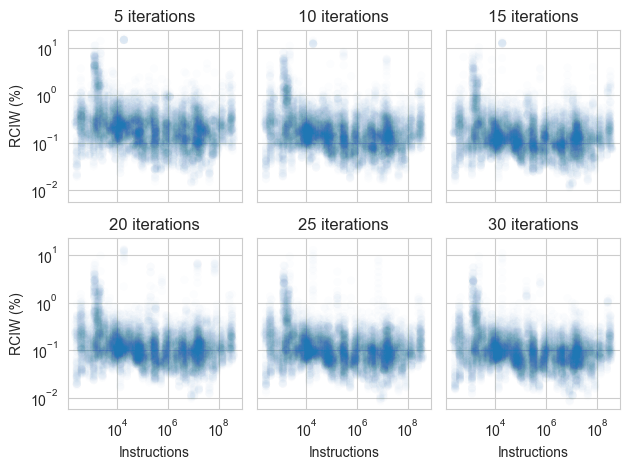

In [126]:
# instruction_sample_rciw = instruction_rciw.copy(deep=True).reset_index()
# instruction_sample_rciw['num_samples'] = instruction_sample_rciw['iterations'] * instruction_sample_rciw['samples']
# total_samples = total_samples.sort_values(['rciw']).drop_duplicates(['bench', 'num_samples'],keep='last')# instruction_rciw = rciw.join(actual_instr, on='bench', how='inner')

# sns.scatterplot(instruction_sample_rciw, x='instructions', y='rciw', hue='num_samples')
# plt.yscale('log')
# plt.legend(loc='upper center')

# iters = range(1,31)
iters = range(5, 31, 5)
fig, axs = plt.subplots(2, 3, sharex=True, sharey=True)
for idx, s in enumerate(iters):
    ax = axs.flatten()[idx]
    sns.scatterplot(instruction_rciw.loc[:, s, :], x='instructions', y='rciw', ax=ax, alpha=0.01, edgecolors="none")
    ax.set_title(f"{s} iterations")
    ax.set_ylabel("RCIW (%)")
    ax.set_xlabel("Instructions")
    # ax.set_ylim([0, 20])
plt.yscale('log')
plt.xscale('log')
plt.tight_layout()

min -0.288; med: -0.232; max: -0.151
min 7.59e-16; med: 1.2e-10; max: 3.38e-05


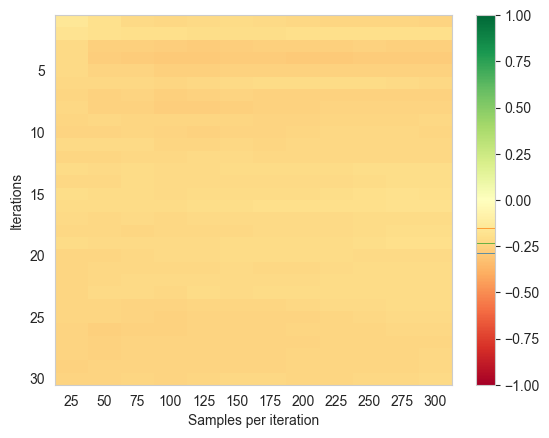

In [127]:
coeff = []
pval = []
for iteration in range(ITERATIONS):
    for samples in SAMPLES_PER_ITERATION_RANGE:
        # print()
        selection = instruction_rciw.loc[slice(None), iteration + 1, samples]
        # print(selection)
        # pearson = np.corrcoef(selection['rciw'], selection['instructions'])[0][1]
        spearman = stats.spearmanr(selection['rciw'], selection['instructions'])
        
        coeff.append(spearman.statistic)
        pval.append(spearman.pvalue)
coeff = np.array(coeff).reshape(ITERATIONS, len(SAMPLES_PER_ITERATION_RANGE))
pval = np.array(pval).reshape(ITERATIONS, len(SAMPLES_PER_ITERATION_RANGE))
plt.xlabel("Samples per iteration")
plt.xticks(range(0, len(SAMPLES_PER_ITERATION_RANGE), 1),
           [label for id, label in enumerate(SAMPLES_PER_ITERATION_RANGE) if id % 1 == 0])
plt.imshow(coeff, cmap='RdYlGn', aspect='auto', vmin=-1, vmax=1)
plt.yticks(range(4, ITERATIONS, 5), range(5, ITERATIONS + 1, 5))
cb = plt.colorbar()
plt.grid(False)
cb.ax.plot([[-0.288, -0.151, -0.232], [-0.288, -0.151, -0.232]], linewidth=0.5)
plt.ylabel("Iterations")
print(f"min {coeff[:, :].min():.3}; med: {np.median(coeff):.3}; max: {coeff.max():.3}")
print(f"min {pval[:, :].min():.3}; med: {np.median(pval):.3}; max: {pval.max():.3}")

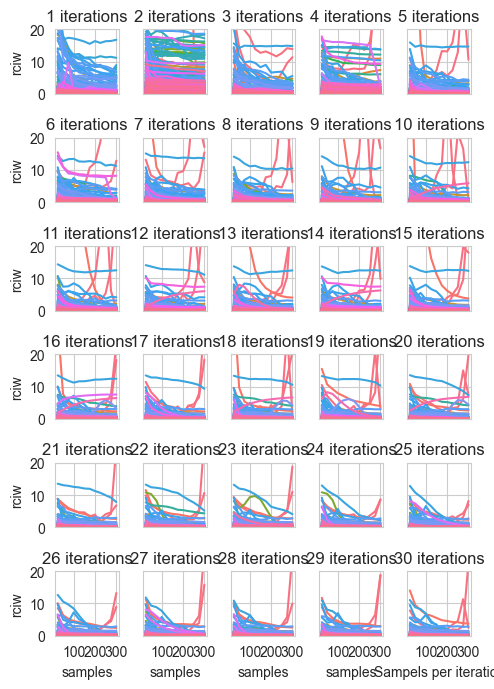

In [145]:
# iters = range(1,31)
iters = range(1, 31)
fig, axs = plt.subplots(6, 5, sharex=True, sharey=True, figsize=(5, 7))
# local = rciw.loc[(slice(None), i, slice(None))]
ll = rciw.copy()
ll['rciw'] = ll['rciw'] * 100
for idx, s in enumerate(iters):
    ax = axs.flatten()[idx]
    sns.lineplot(ll.loc[(slice(None), s, slice(None))], x='samples', y='rciw', units='bench', hue='bench', legend=False,
                 ax=ax, estimator=None)
    ax.set_title(f"{s} iterations")
    # ax.set_ylabel("RCIW (%)")
    # ax.set_xlabel("Samples per iteration")
    ax.set_ylim([0, 20])
plt.xlabel("Sampels per iteration")
plt.ylabel("RCIW (%)")
plt.tight_layout()

In [129]:
# rciw.reset_index()[(rciw.reset_index()['rciw'] > .10) & (rciw.reset_index()['iterations'] > 4)].iteration_groups('bench').count()

5 6
5 8
7 8
12 18
13 14
13 15
13 18
13 20
13 22
13 23
14 18
15 18
15 20
15 22
15 23
16 17
16 18
16 19
16 20
16 21
16 22
16 23
16 24
16 25
16 26
16 30
17 18
17 20
17 22
17 23
19 20
19 22
19 23
20 23
21 22
21 23
21 24
21 26
21 30
22 23
24 26
25 26
25 30
27 28
27 29
27 30
28 29
28 30
29 30


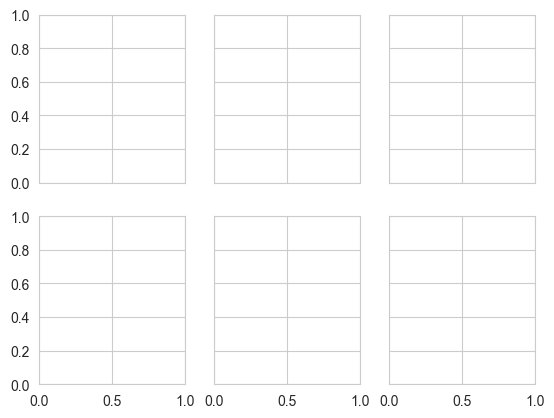

In [130]:
from math import sqrt
# iters = range(1,31)
iters = range(5, 31, 5)
fig, axs = plt.subplots(2, 3, sharex=True, sharey=True)
# local = rciw.loc[(slice(None), i, slice(None))]
import itertools

# An = lambda n: -(0.76213/n)-(0.86413/(n*n))
# c5 = lambda n: 1 + An(n)
# A5n = lambda n: 3/c5(n)*sqrt(n)
# print(1/An(5))
# norm = scipy.stats.norm(0, 1)
# print(1/norm.ppf(3/4))
# for idx, s in enumerate(iters):
#     ax = axs.flatten()[idx]
#     data = rmad.loc[(slice(None), s, slice(None))]
#     data['rmad'] = data['rmad']
# 
#     sns.lineplot(data, x='samples', y='rmad', units='bench', hue='bench',
#                  legend=False, ax=ax, estimator=None)
#     ax.set_title(f"{s} iterations")
#     ax.set_xlabel("Samples per iteration")
#     # ax.set_ylim([0, 1.5])
# plt.tight_layout()
# plt.yscale('log')

for (l1, d1), (l2, d2) in itertools.combinations(rmad.groupby('iterations'), r=2):
    if l1 < 5 or l2 < 5:
        # print(l1)
        continue
    w = scipy.stats.wilcoxon(d1, d2, alternative='greater')
    if w.pvalue < 0.05:
        print(l1, l2)
    # break


rciw
bench                                             samples          
parity-common/eq_self/0xffff…ffff                 25       0.001288
                                                  50       0.000975
                                                  75       0.000797
                                                  100      0.000705
                                                  125      0.000635
...                                                             ...
pulldown-cmark/advanced_pathological_codeblocks/3 200      0.000863
                                                  225      0.000837
                                                  250      0.000781
                                                  275      0.000721
                                                  300      0.000679

[9948 rows x 1 columns]

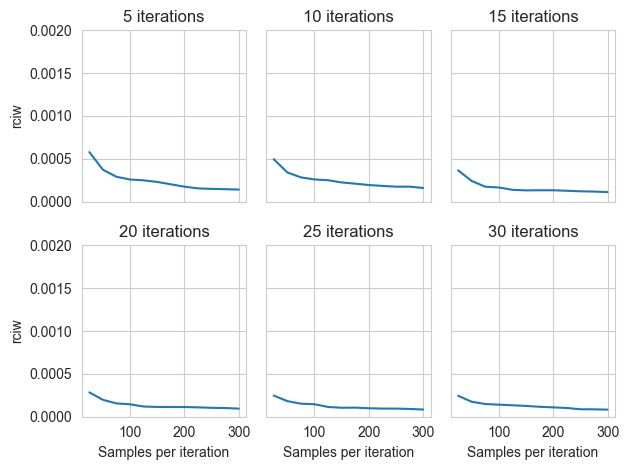

In [131]:
# iters = range(1,31)
iters = range(5, 31, 5)
fig, axs = plt.subplots(2, 3, sharex=True, sharey=True)
# local = rciw.loc[(slice(None), i, slice(None))]

for idx, s in enumerate(iters):
    ax = axs.flatten()[idx]
    sns.lineplot(rciw.groupby(["iterations", "samples"]).min().loc[(s, slice(None))], x='samples', y='rciw', 
                 legend=False, ax=ax, estimator=None)
    ax.set_title(f"{s} iterations")
    ax.set_xlabel("Samples per iteration")
    ax.set_ylim([0, 0.2/100])
plt.tight_layout()
# plt.yscale('log')
rciw.loc[(slice(None), 15, slice(None))]


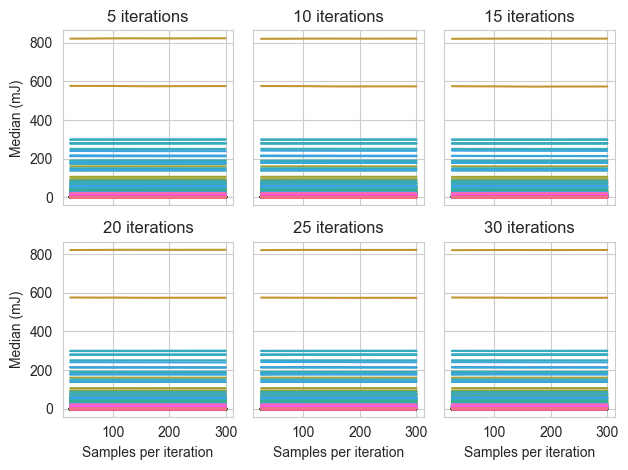

In [132]:
# iters = range(1,31)
iters = range(5, 31, 5)
fig, axs = plt.subplots(2, 3, sharex=True, sharey=True)
# local = rciw.loc[(slice(None), i, slice(None))]

for idx, s in enumerate(iters):
    ax = axs.flatten()[idx]
    sns.lineplot(medians.loc[(slice(None), s, slice(None))], x='samples', y='median', units='bench', hue='bench',
                 legend=False, ax=ax, estimator=None)
    ax.set_title(f"{s} iterations")
    ax.set_xlabel("Samples per iteration")
    ax.set_ylabel("Median (mJ)")
    # ax.set_ylim([0, 1.5])
plt.tight_layout()
# plt.yscale('log')

0. 50
1. 100
2. 150
3. 200
4. 250
5. 300


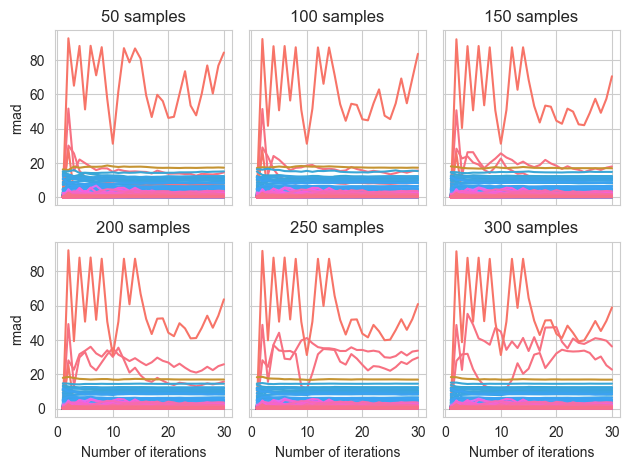

In [133]:
# iters = range(1,31)
import math

samps = range(50, 301, 50)
fig, axs = plt.subplots(2, math.floor(len(samps) / 2), sharex=True, sharey=True)
# local = rciw.loc[(slice(None), i, slice(None))]
ll = rmad.copy()
ll['rmad'] = ll['rmad'] * 100
for idx, s in enumerate(samps):
    print(f"{idx}. {s}")
    ax = axs.flatten()[idx]
    sns.lineplot(ll.loc[(slice(None), slice(None), s)], x='iterations', y='rmad', units='bench', hue='bench',
                 legend=False, ax=ax, estimator=None)
    ax.set_title(f"{s} samples")
    ax.set_xlabel("Number of iterations")
    # ax.set_ylim([0, 20])
plt.tight_layout()
# plt.yscale('log')

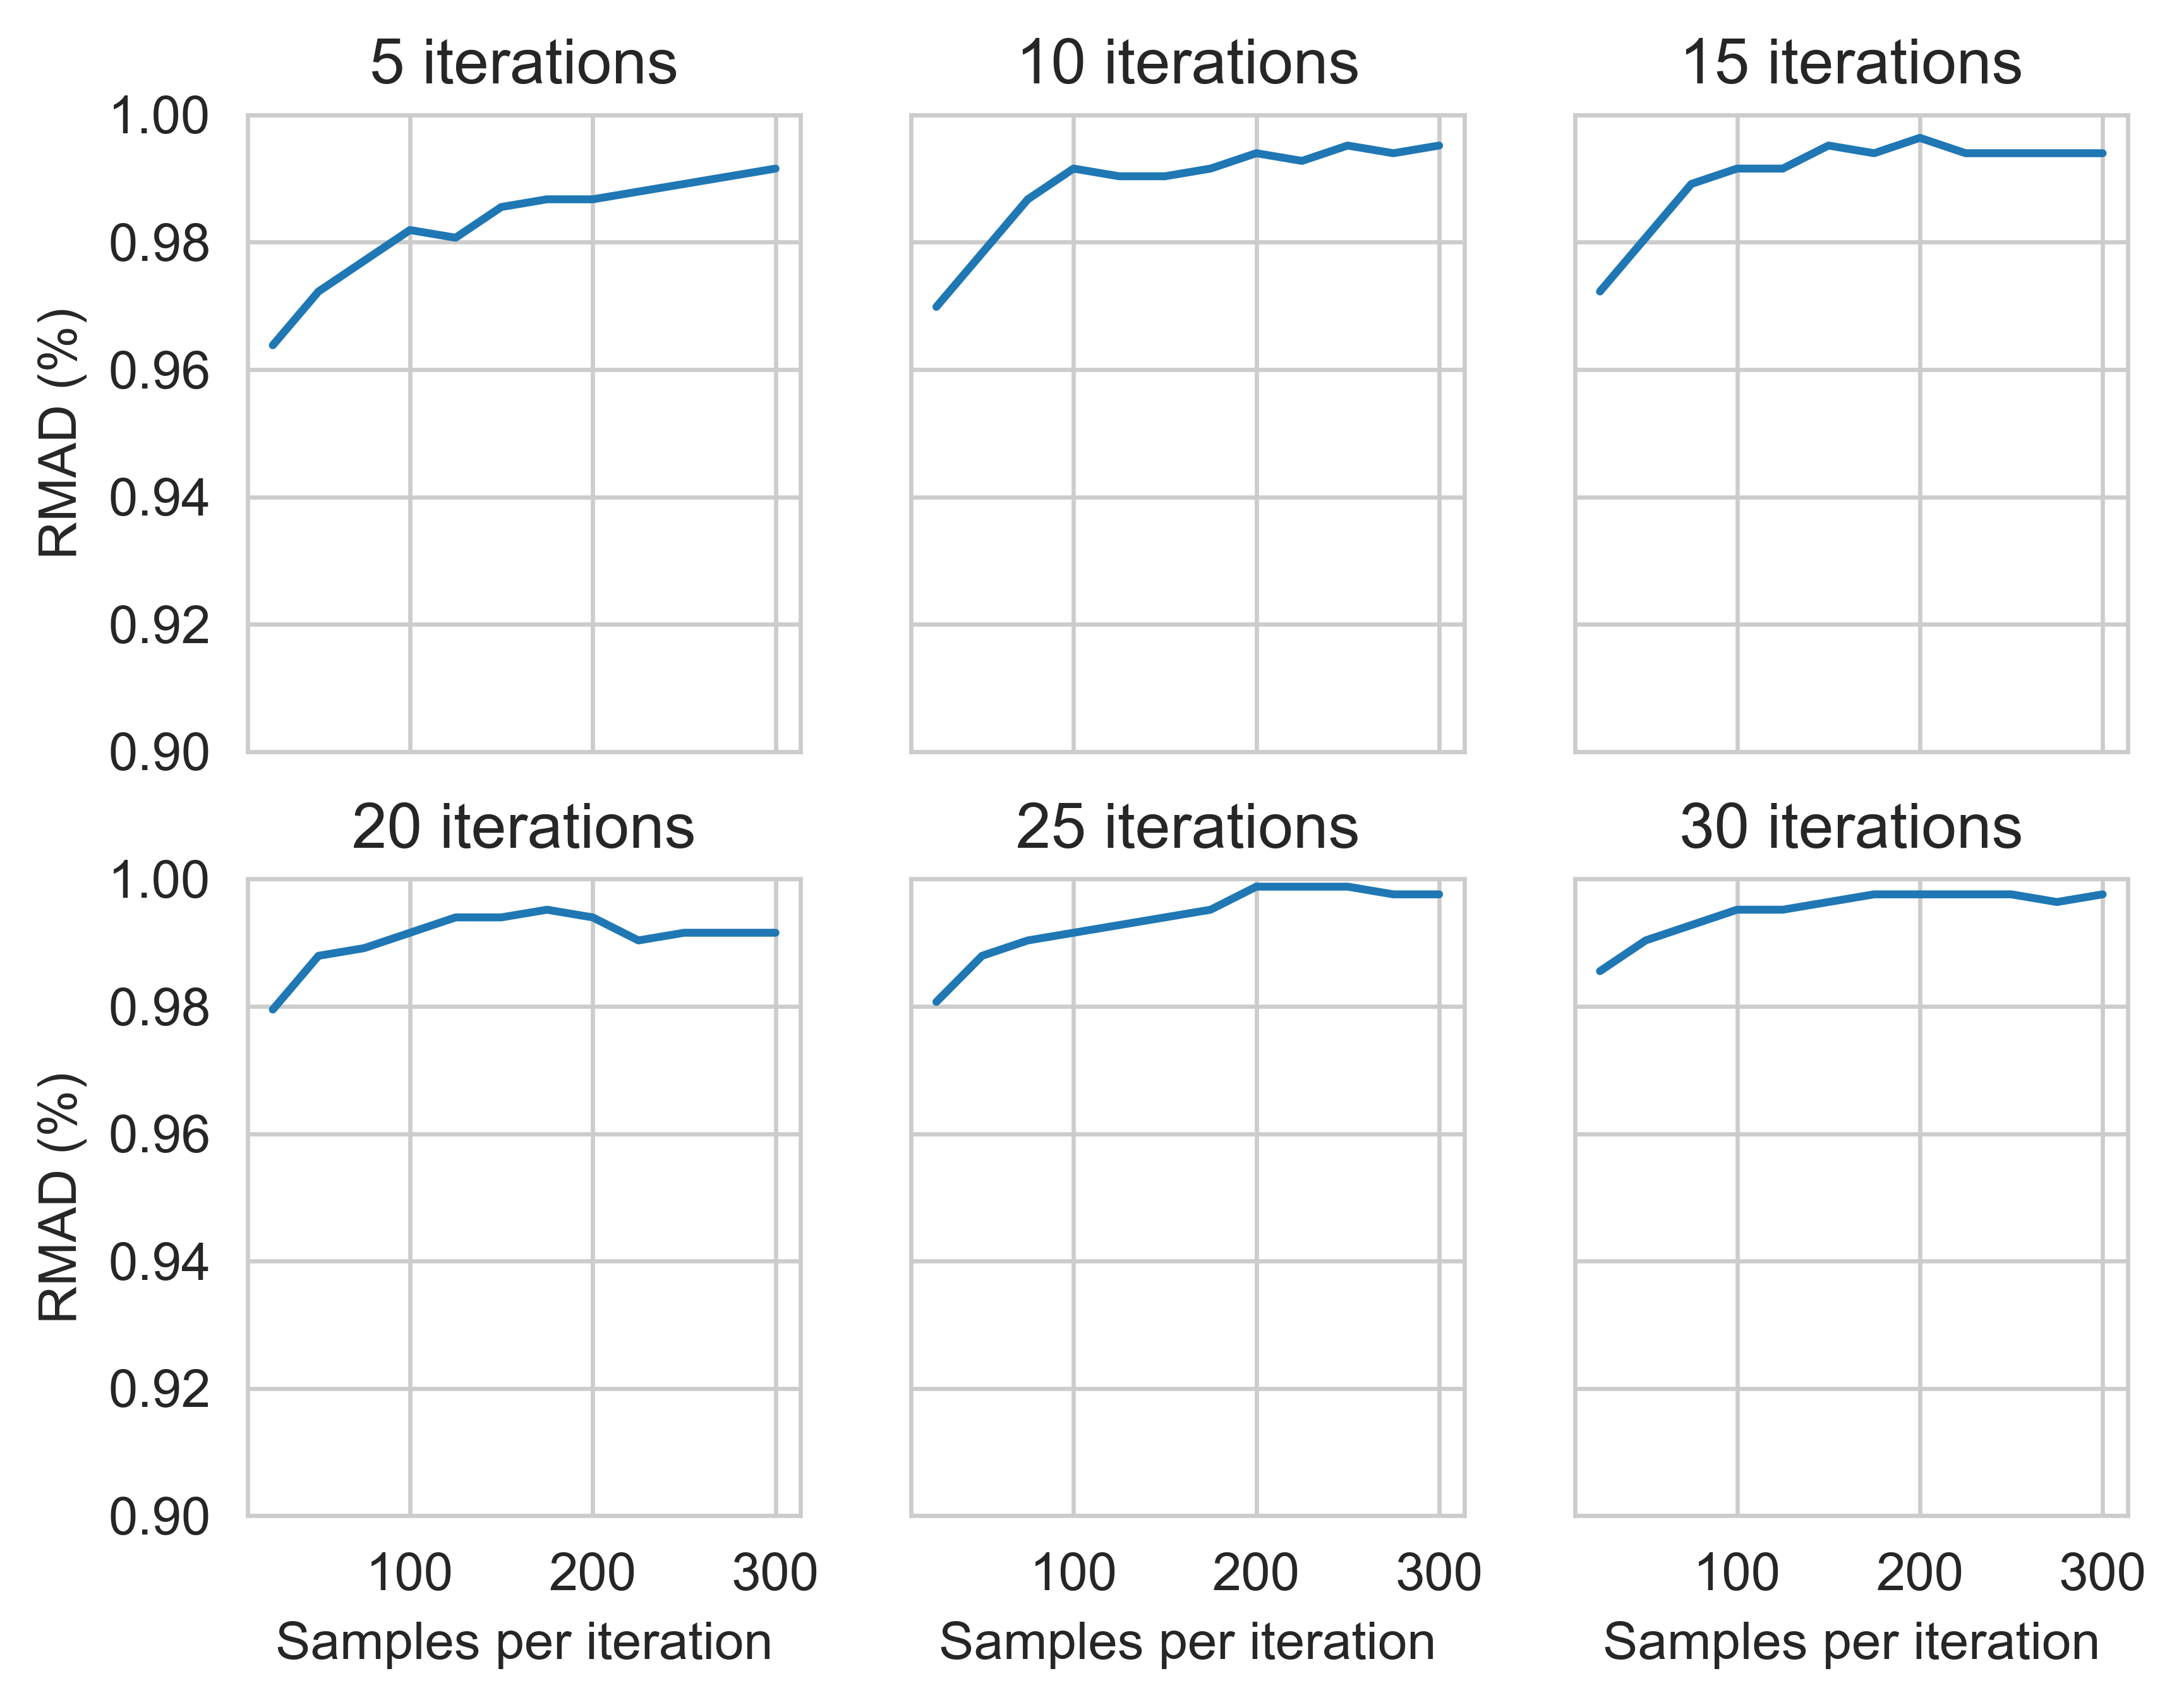

In [134]:

iters = range(5, 31, 5)
fig, axs = plt.subplots(2, 3, sharex=True, sharey=True, dpi=600)
# local = rciw.loc[(slice(None), i, slice(None))]
ll = rciw.copy()
ll['rciw'] = ll['rciw'] * 100
for idx, s in enumerate(iters):
    ax = axs.flatten()[idx]
    dd = ll.loc[(slice(None), s, slice(None))]
    # dd['stable'] = (dd['rciw'] < 5).groupby('samples').mean()
    
    sns.lineplot((dd['rciw'] < 3).groupby('samples').mean(), legend=False,
                 ax=ax, estimator=None)
    ax.set_title(f"{s} iterations")
    ax.set_ylabel("RMAD (%)")
    ax.set_xlabel("Samples per iteration")
    ax.set_ylim([0.9, 1])
    # break
# plt.tight_layout()
# (dd['rciw'] < 5).groupby('samples').mean()

In [135]:
ll = rciw.reset_index(level='samples')
# ll['rciw'] = ll['rciw'] * 1000
# ll['rciw'] *= 100
ll.groupby(['iterations', 'samples']).apply(lambda df: custom_mquantiles_cimh_hd(df['rciw'], prob=[0.5]),include_groups=False).reset_index().rename(columns={0: 'median'})
ll.groupby(['iterations', 'samples']).apply(lambda df: scipy.stats.normaltest(df['rciw']).statistic,include_groups=False).reset_index().rename(columns={0: 'normal'})

iterations  samples       normal
0             1       25   988.099360
1             1       50   958.237179
2             1       75   946.757398
3             1      100  1000.498070
4             1      125  1050.400942
..          ...      ...          ...
355          30      200  1365.106601
356          30      225  1385.961390
357          30      250  1478.509947
358          30      275  1899.367726
359          30      300  2119.383125

[360 rows x 3 columns]

Text(0.5, 0, '(b) Number of iterations used')

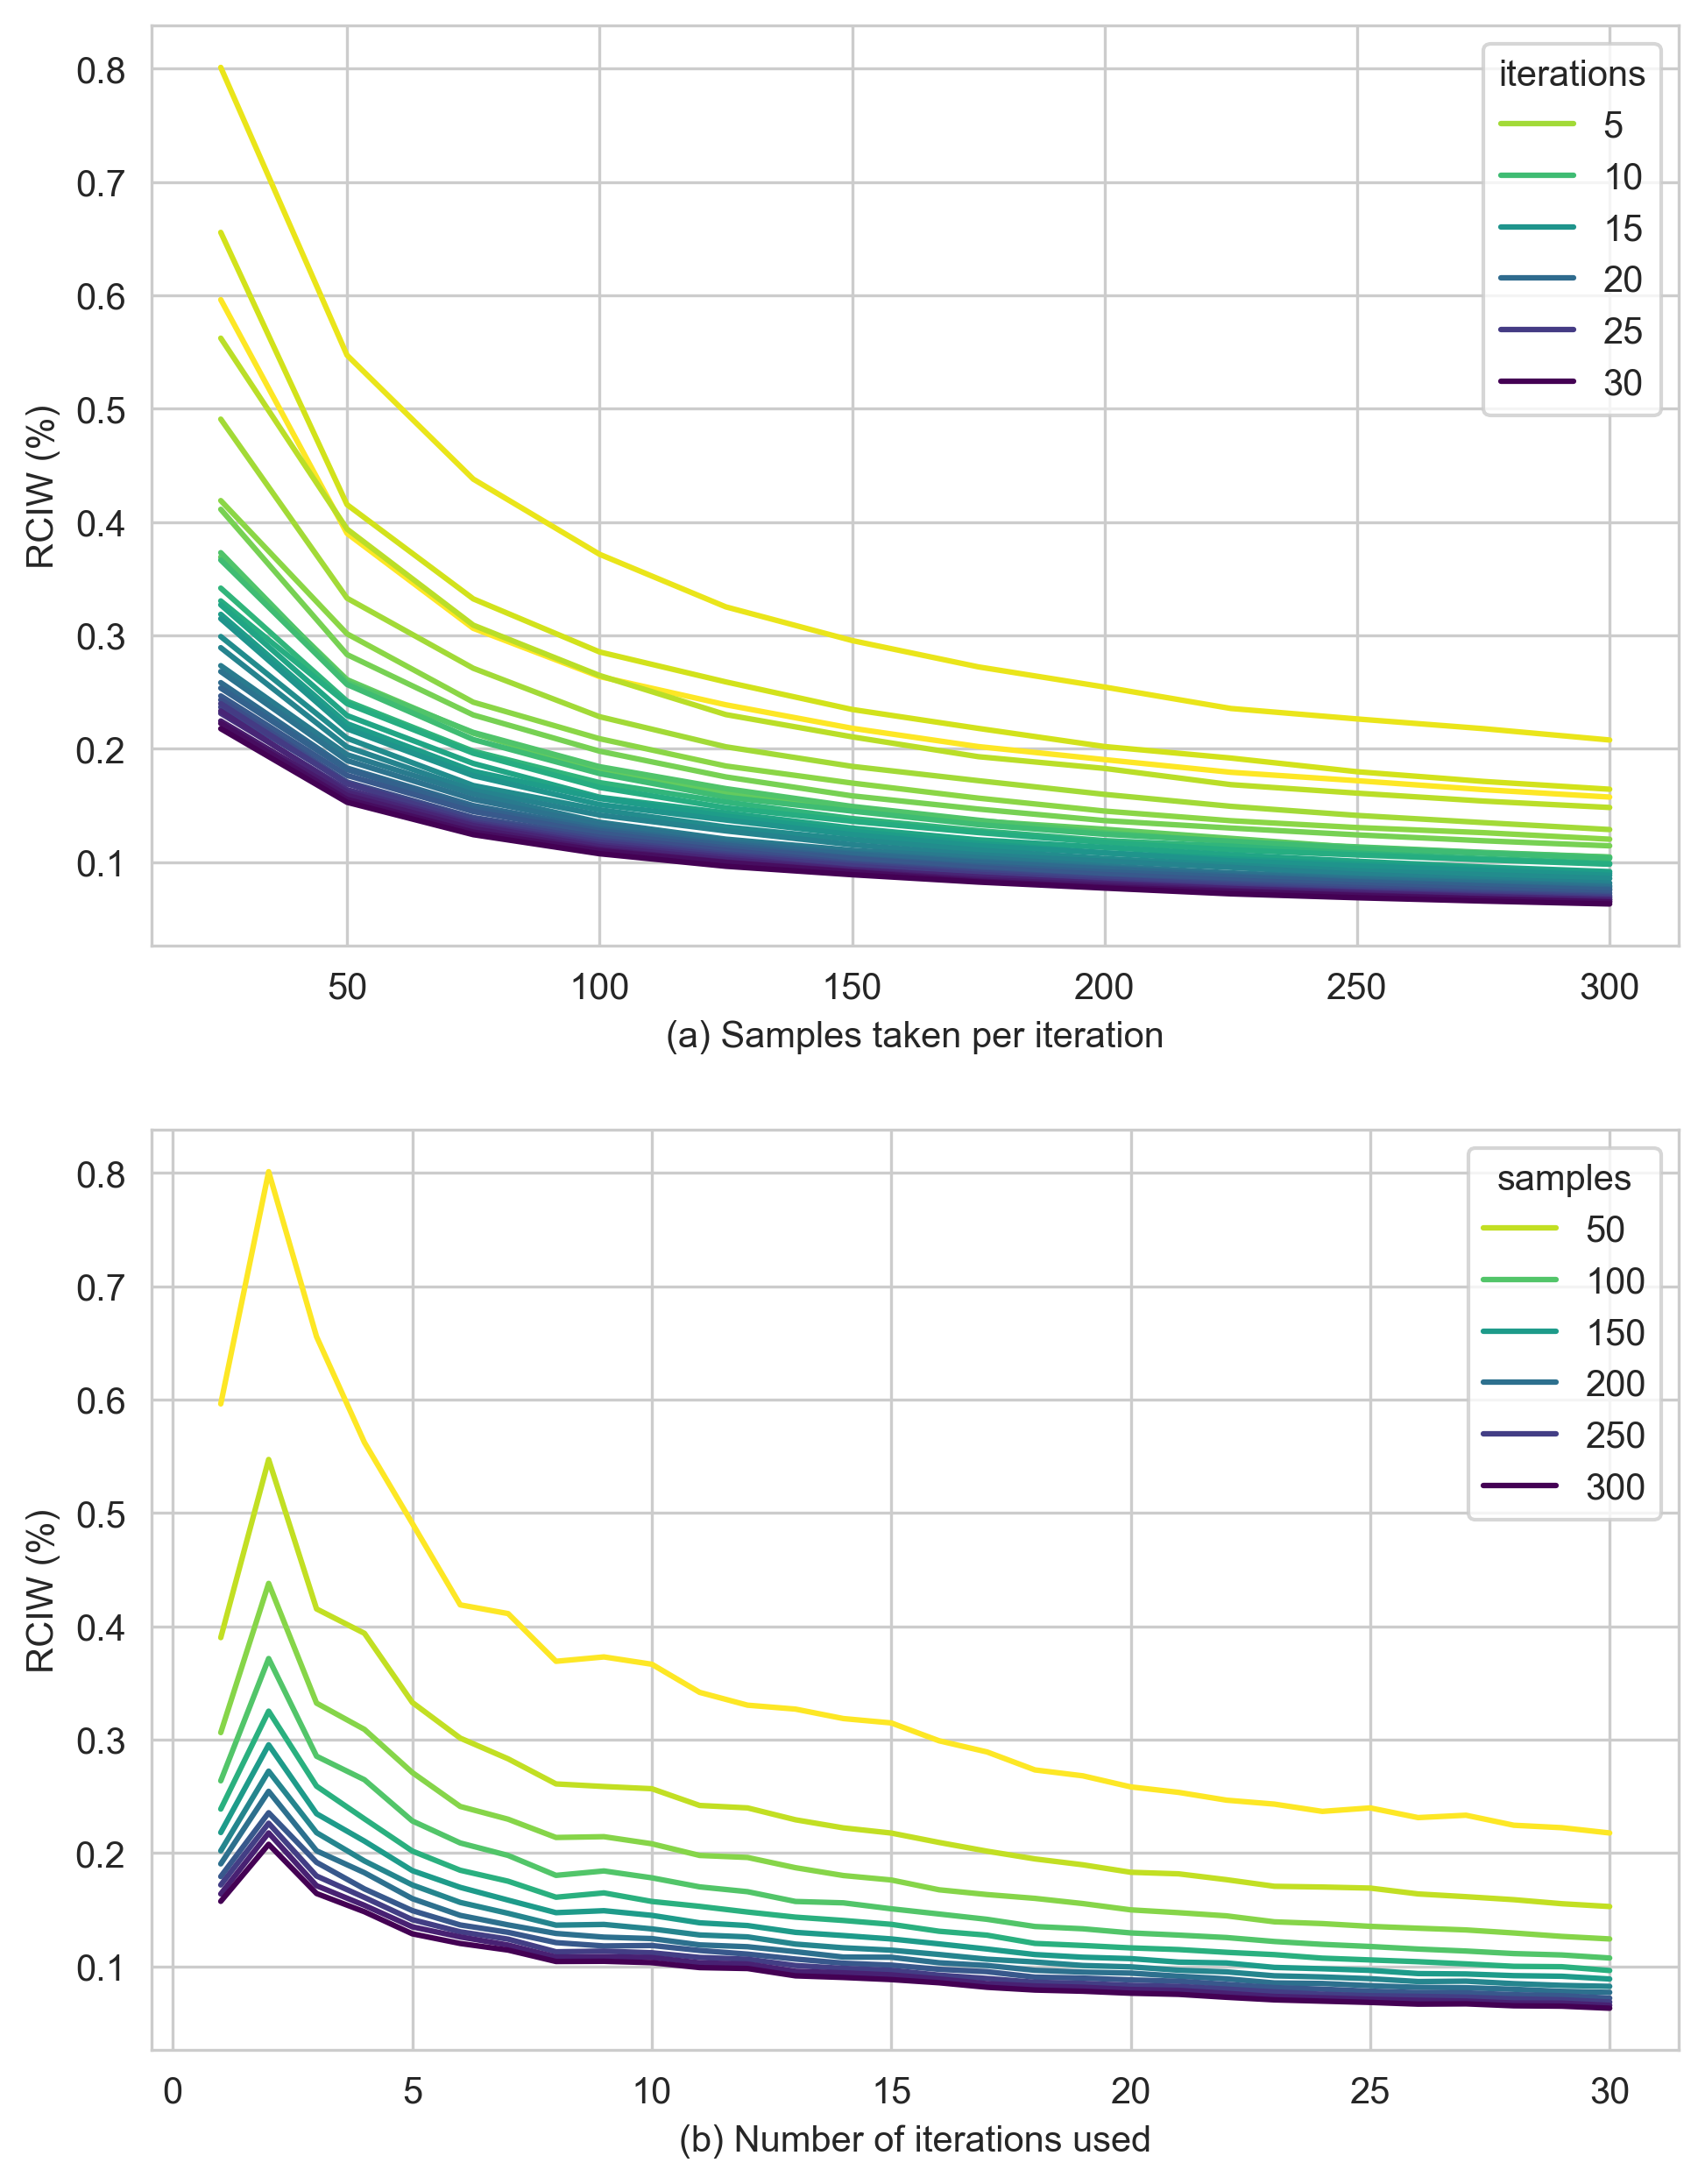

In [136]:
def med_hj(data):
    return float(np.ma.getdata(scipy.stats.mstats.hdmedian(data, axis=0)))

ll = rciw.reset_index(level='samples')
# ll['rciw'] = ll['rciw'] * 1000
ll['rciw'] *= 100
regular_medians = ll.groupby(['iterations', 'samples']).median()
hj_medians = (ll.groupby(['iterations', 'samples']).apply(lambda df: med_hj(df['rciw']),
                                                         include_groups=False).reset_index()
              .rename(columns={0: 'rciw'})
              )
fig, axs = plt.subplots(2,1, figsize=(7.5, 10), dpi=300)

sns.lineplot(hj_medians, x='samples', y='rciw', units='iterations', hue='iterations', legend=True, palette='viridis_r',
             estimator=None, ax=axs[0])
sns.lineplot(hj_medians, x='iterations', y='rciw', units='samples', hue='samples', legend=True, palette='viridis_r',
             estimator=None, ax=axs[1])
# 
axs[0].set_xlabel("(a) Samples taken per iteration")
axs[1].set_ylabel("RCIW (%)")
axs[0].set_ylabel("RCIW (%)")
axs[1].set_xlabel("(b) Number of iterations used")
# axs[0].set_yscale("log")
# axs[1].set_yscale('log')
# 
# 
# def is_monotonic_decreasing(data) -> bool:
#     return not not (np.diff(data) < 0).all()
# # ll
# [is_monotonic_decreasing(group[group['iterations'] > 15]['rciw']) for  label, group in hj_medians.groupby('samples')]# ll.groupby(['iterations','samples']).median()
# [is_monotonic_decreasing(group['rciw']) for  label, group in hj_medians.groupby('iterations')]# ll.groupby(['iterations','samples']).median()

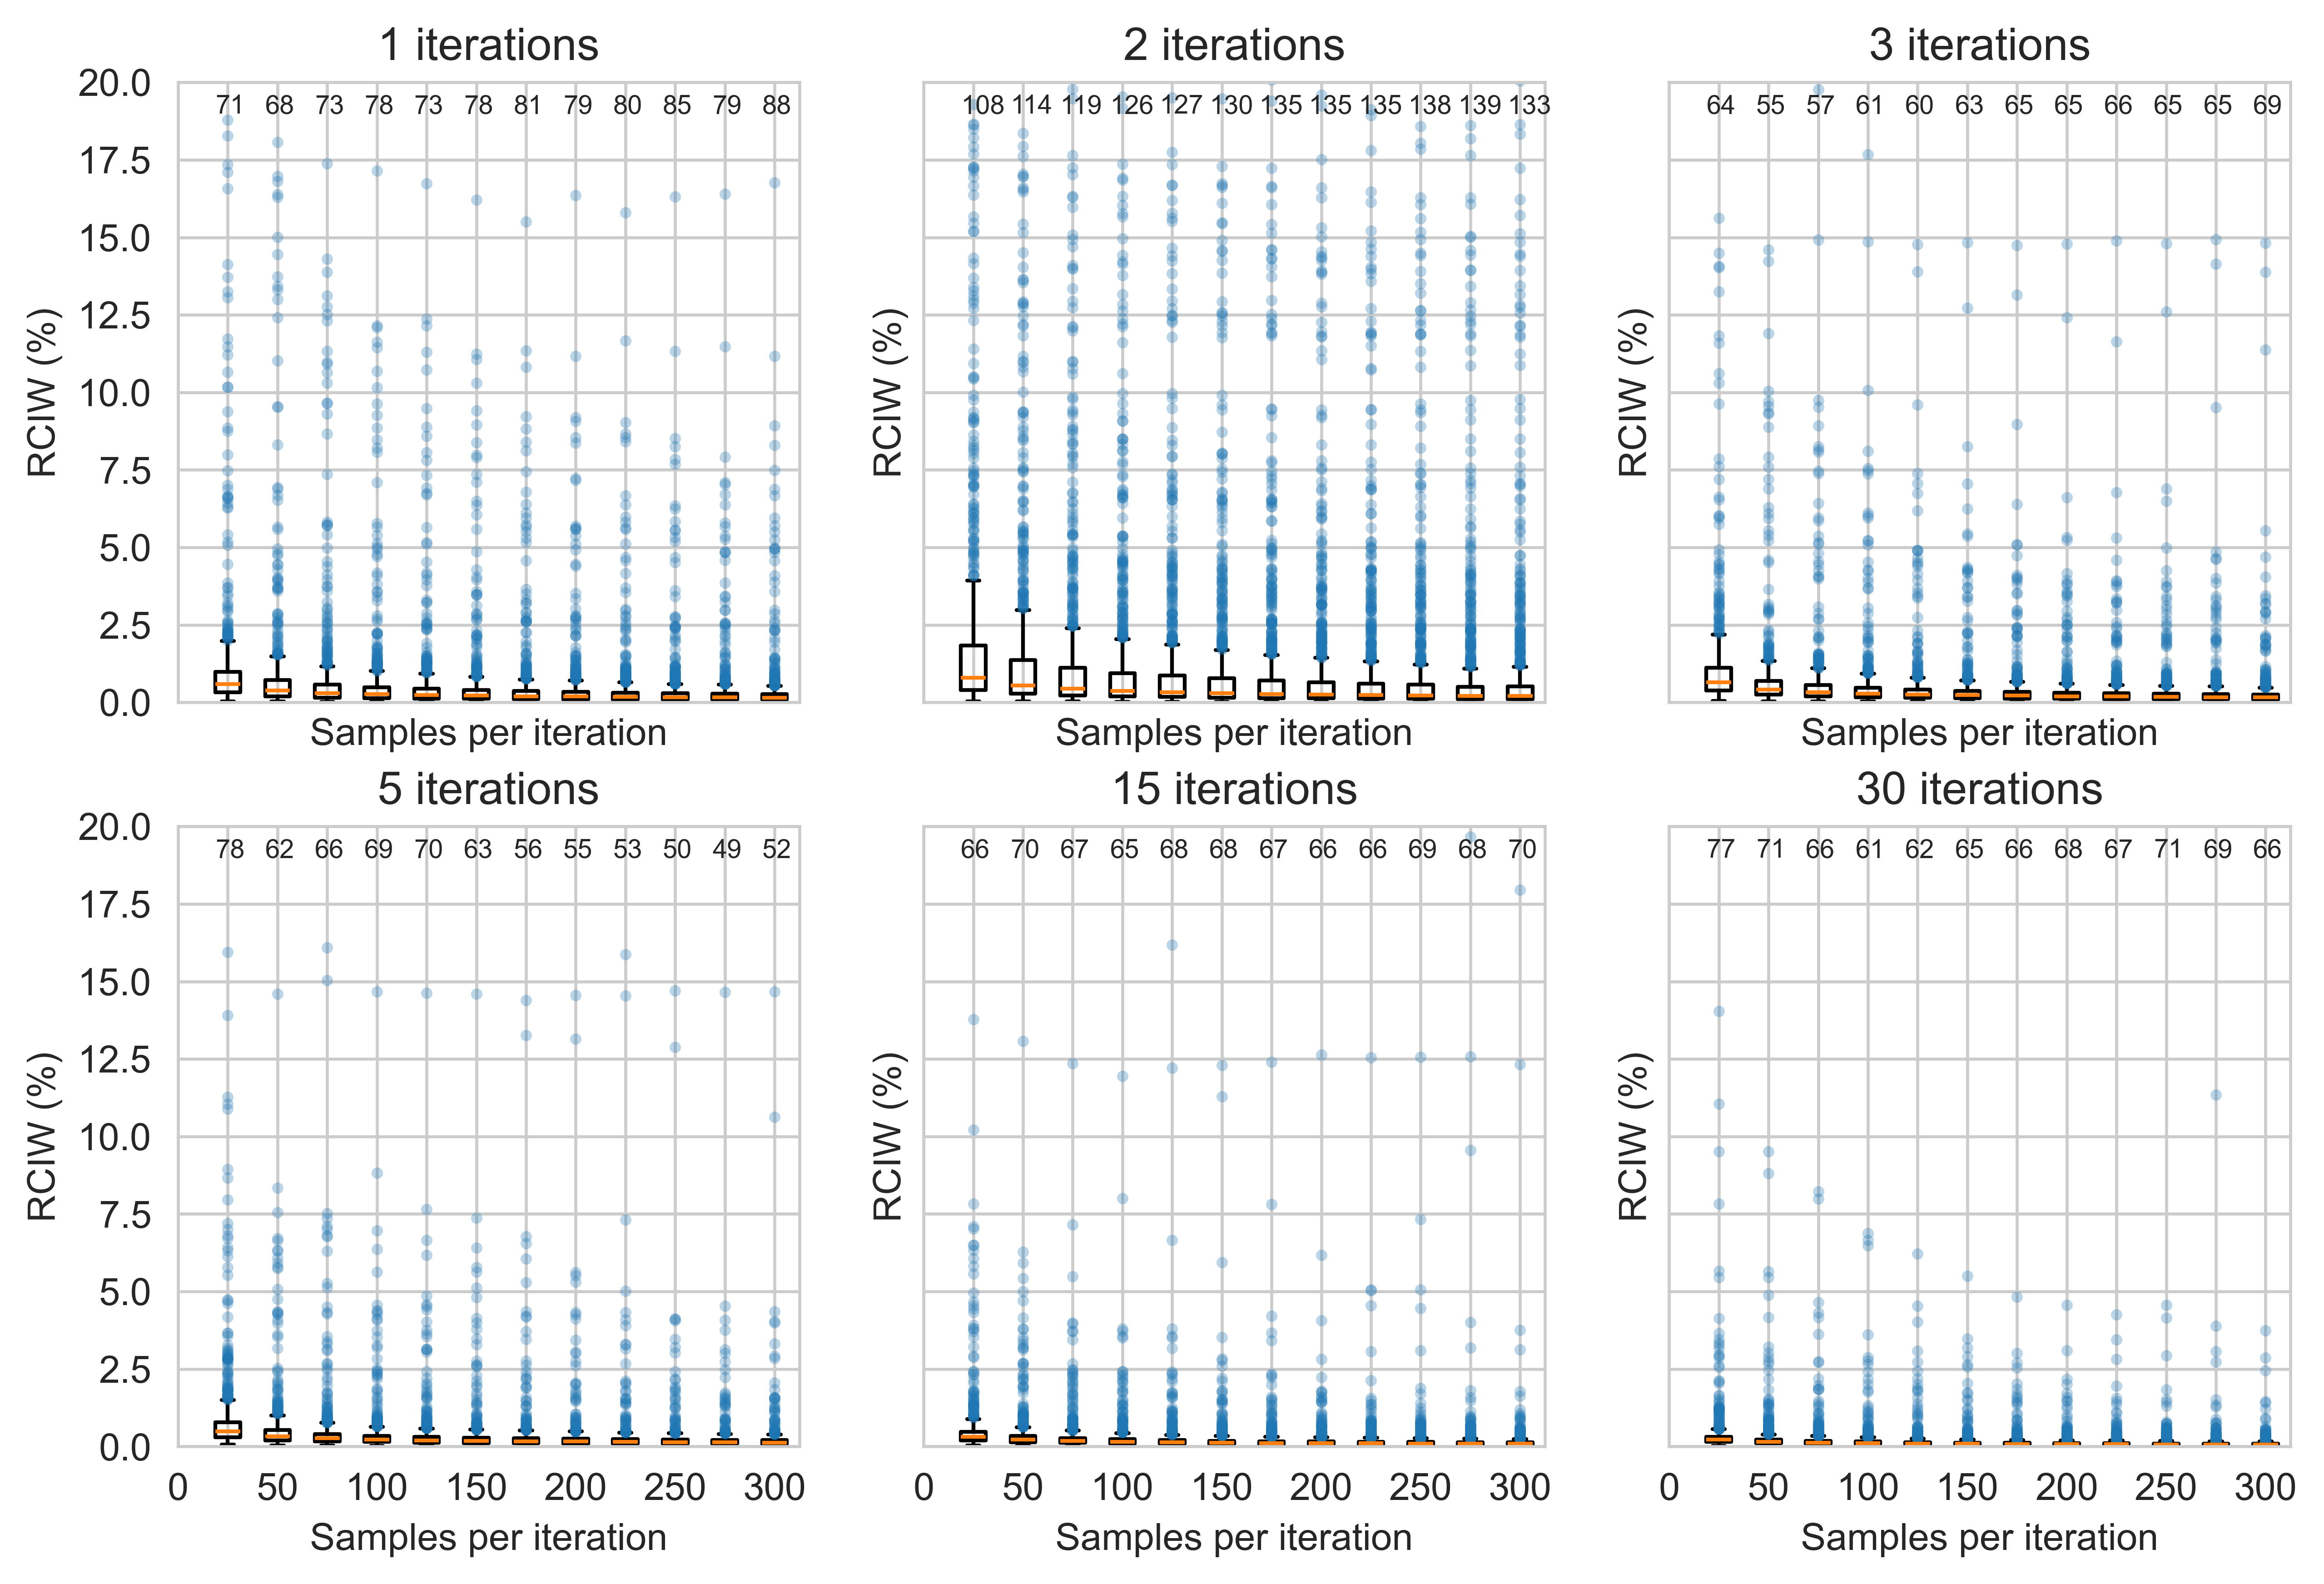

In [137]:
# iters = range(1,31)
import operator
iters = range(5, 31, 5)
fig, axs = plt.subplots(2, 3, sharex=True, sharey=True, figsize=(10, 6.5), dpi=600)
# local = rciw.loc[(slice(None), i, slice(None))]
ll = rciw.reset_index(level='samples')
# ll.rename('rciw')
ll['rciw'] = ll['rciw'] * 100
for idx, s in enumerate([1,2,3,5,15,30]):
    ax = axs.flatten()[idx]
    box = ax.boxplot(list(map(operator.itemgetter(1), ll.loc[(slice(None), s, slice(None))].reset_index().groupby(by='samples')['rciw'])), flierprops={"marker":".", "fillstyle": "full", "markerfacecolor":"tab:blue", "alpha": 0.3, "markeredgecolor": "none"}) 
                #orient='v', x='samples', y='rciw', legend=True,
                 # flierprops={"marker":".", "fillstyle": "full", "markerfacecolor":"tab:blue", "alpha": 0.3, "markeredgecolor": "none"})
                # )
    ax.set_title(f"{s} iterations")
    ax.set_ylabel("RCIW (%)")
    ax.set_xlabel("Samples per iteration")
    ax.set_ylim([0, 20])
    ax.set_xticks(range(13), [str(x) if x % 2 == 0 else "" for x in (np.arange(13) * 25)])
    outliers = list(map(lambda line2d: len(line2d.get_xdata()), box['fliers']))
    for x, outlier in enumerate(outliers):
        ax.text(x + 0.75, 19, str(outlier), fontsize='x-small')
    
    # print(outliers)
# 
# list(map(operator.itemgetter(1), ))
# plt.tight_layout()
# for group in ll.loc[(slice(None), 5, slice(None))].reset_index().groupby(by='samples')['rciw']:
#     print(group[1].values)

AttributeError: 'AxisInfo' object has no attribute 'id'

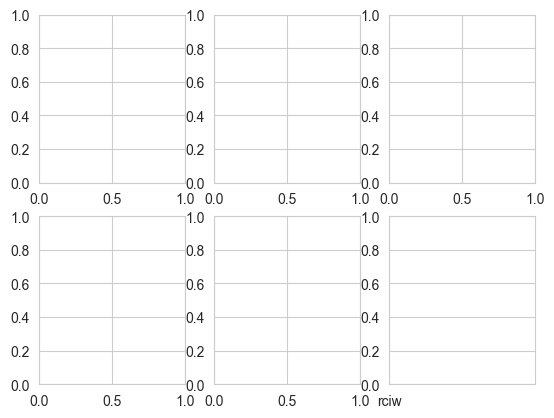

In [138]:
# # iters = range(1,31)
# # iters = range(5, 31, 5)
# fig, axs = plt.subplots(2, 3) #, sharex=True, sharey=True, figsize=(10, 6.5))
# # local = rciw.loc[(slice(None), i, slice(None))]
# # ll = rciw.reset_index(level='iterations')
# ll = rciw.astype(float)
# ll['rciw'] = ll['rciw'] * 100
# for idx, s in enumerate([50, 100, 150, 200, 250, 300]):
#     ax = axs.flatten()[idx]
#     # sns.boxplot(ll.loc[(slice(None),  slice(None), s)], x='iterations', y='rciw', legend=False,
#     #              ax=ax, flierprops={"marker":".", "fillstyle": "full", "markerfacecolor":"tab:blue", "alpha": 0.3, "markeredgecolor": "none"})
#     # 
#     sns.boxplot(ll.loc[(slice(None),  slice(None), s)])
#     ax.set_title(f"{s} samples")
#     # ax.set_ylabel("RCIW (%)")
#     ax.set_xlabel("Samples per iteration")
#     # ax.set_ylim([0, 17.5 / 10])
# # 
# # 
# # plt.tight_layout()
# ll.loc[(slice(None), slice(None), 50)].reset_index()

In [ ]:
def med_hj(data):
    return float(np.ma.getdata(scipy.stats.mstats.hdmedian(data, axis=0)))

# ll['rciw'] = ll['rciw'] * 1000
# regular_medians = rciw.groupby(['iterations', 'samples']).median()
hj_medians = (rciw.groupby(['iterations', 'samples']).apply(lambda df: med_hj(df['rciw']) * 100,
                                                         include_groups=False).reset_index()
              .rename(columns={0: 'rciw'})
              ).sort_values(['iterations', 'samples'], ascending=[False, False])
# X1 = rciw.index.get_level_values('iterations').unique()
# Y1 = rciw.index.get_level_values('iterations').unique()


# X1, Y1 = np.meshgrid(hj_medians['iterations'].unique(), hj_medians['samples'].unique())
cmap_name='viridis_r'
cmap =matplotlib.colormaps[cmap_name].resampled(16)

vmax = hj_medians['rciw'].max()
vmin = hj_medians['rciw'].min()
vcenter = med_hj(hj_medians['rciw'])
# cmap = matplotlib.cm.ScalarMappable(cmap='viridis', norm=matplotlib.colors.Normalize(vmin=hj_medians['rciw'].min(), vmax=hj_medians['rciw'].max()))
# colors = cmap(matplotlib.colors.TwoSlopeNorm(vmax=vmax, vmin=vmin, vcenter=.2)(hj_medians['rciw']))
colors = cmap(matplotlib.colors.Normalize(vmax=vmax, vmin=vmin, )(hj_medians['rciw']))
edges = matplotlib.colormaps['Reds'](matplotlib.colors.Normalize(vmax=9000, vmin=0)(hj_medians['iterations'] * hj_medians['samples']))

ys = np.arange(25, 300, 25)
xs = 1500/ ys

axes = plt.axes (projection='3d', azim=45)
# axes.set_xlim([1, 30])
# axes.set_ylim([25, 300])

bars = axes.bar3d(hj_medians['iterations'], hj_medians['samples'], 0, 1, 25, hj_medians['rciw'],color = colors, shade=False, linewidth=0.2, sort_zpos=hj_medians['rciw'], zsort='max', )
axes.set_xlabel("Iterations")
axes.set_ylabel("Samples")
axes.set_zlabel("RCIW", rotation='vertical')


fig.colorbar(matplotlib.cm.ScalarMappable(norm=matplotlib.colors.Normalize(vmax=vmax, vmin=vmin), cmap=cmap), ax=axes,  )
# hj_medians

In [ ]:
def med_hj(data):
    return float(np.ma.getdata(scipy.stats.mstats.hdmedian(data, axis=0)))

# ll['rciw'] = ll['rciw'] * 1000
# regular_medians = rciw.groupby(['iterations', 'samples']).median()
hj_medians = (rciw.groupby(['iterations', 'samples']).apply(lambda df: med_hj(df['rciw']) * 100,
                                                         include_groups=False).reset_index()
              .rename(columns={0: 'rciw'})
              ).sort_values(['iterations', 'samples'], ascending=[False, False])
# X1 = rciw.index.get_level_values('iterations').unique()
# Y1 = rciw.index.get_level_values('iterations').unique()


# X1, Y1 = np.meshgrid(hj_medians['iterations'].unique(), hj_medians['samples'].unique())
cmap_name='viridis_r'
cmap =matplotlib.colormaps[cmap_name].resampled(36)

vmax = 9000
vmin = 0

# cmap = matplotlib.cm.ScalarMappable(cmap='viridis', norm=matplotlib.colors.Normalize(vmin=hj_medians['rciw'].min(), vmax=hj_medians['rciw'].max()))
# colors = cmap(matplotlib.colors.TwoSlopeNorm(vmax=vmax, vmin=vmin, vcenter=.2)(hj_medians['rciw']))
colors = cmap(matplotlib.colors.Normalize( vmin=vmin, )(hj_medians['iterations'] * hj_medians['samples']))
edges = matplotlib.colormaps[cmap_name].resampled(36)(matplotlib.colors.Normalize(vmax=vmax, vmin=vmin, )(hj_medians['iterations'] * hj_medians['samples']))
# ys = np.arange(25, 300, 25)
# xs = 1500/ ys

axes = plt.axes (projection='3d', azim=45, elev=30, proj_type='ortho')
# axes.set_xlim([1, 30])
# axes.set_ylim([25, 300])
# axes.set_zlim([0, 0.2])

bars = axes.bar3d(hj_medians['iterations'], hj_medians['samples'], 0, 1, 25, hj_medians['rciw'],color = colors, shade=False, linewidth=0.1, sort_zpos=hj_medians['rciw'], zsort='max')
axes.set_xlabel("Iterations")
axes.set_ylabel("Samples per iteration")
# axes.set_zlabel("RCIW", rotation='vertical', labelpad=0)
axes.set_title("RCIW (%)", loc='left', pad=-10, y=0.85)


fig.colorbar(matplotlib.cm.ScalarMappable(norm=matplotlib.colors.Normalize(vmax=vmax, vmin=vmin), cmap=cmap), ax=axes,  label='Total number of samples')
# hj_medians

In [ ]:

outlierdet = rciw.loc[(slice(None), 30, 300)]
# finding the 1st quartile
q1 = np.quantile(outlierdet, 0.25)

# finding the 3rd quartile
q3 = np.quantile(outlierdet, 0.75)
med = np.median(outlierdet)
iqr = q3-q1
upper_bound = q3+(1.5*iqr)
lower_bound = q1-(1.5*iqr)
print(len(outlierdet), len(outlierdet[(outlierdet <= lower_bound) | (outlierdet >= upper_bound)].dropna()))
# outlierdet[(outlierdet <= lower_bound) | (outlierdet >= upper_bound)]

In [ ]:
def func(x, a, b, c, d):
    # return np.log((x + d) / a) / b + c
    return b/(x+a) + c


fitting_data = hj_medians[hj_medians['iterations'] > 4]
fig, axs = plt.subplots(1, 2, figsize=(15, 5), sharey=True)
sns.lineplot(fitting_data, x='samples', y='rciw', units='iterations', hue='iterations', legend=True,
             palette='viridis_r', estimator=None, ax=axs[0])

SSSE = 0
popts = []
from scipy.optimize import curve_fit

for label, group in fitting_data.iteration_groups('iterations'):
    (fit, pcov, info, mesg, ier) = curve_fit(func, xdata=group['samples'], ydata=group['rciw'], full_output=True,
                                             bounds=([0, 0, -1, 0], [np.inf, np.inf, 1, 1]), maxfev=5000)
    sns.lineplot(x=np.arange(25, 300), y=map(lambda x: func(x, *fit), np.arange(25, 300)), ax=axs[0],
                 legend=False, alpha=0.9)
    perr = np.sqrt(np.diag(pcov))
    # print(perr)
    popts.append(fit)
    SSE = np.power(info['fvec'], 2).sum()
    SSSE += SSE
    # print(label, ",", ",".join(map(str, fit)))
print(SSSE)

# print(list(map(lambda x: func(x, *fit), SAMPLES_PER_ITERATION_RANGE)))

In [ ]:

data = np.array([
    [rciw_mjhd(np.array(consumption[bench]).reshape(ITERATIONS, -1)[:, 0], 0.05) for bench in consumption.columns],
    [rciw_mjhd(np.array(consumption[bench]).reshape(ITERATIONS, -1), 0.05) for bench in consumption.columns],
    [rmad_hd(np.array(consumption[bench]).reshape(ITERATIONS, -1)[:, 0]) for bench in consumption.columns],
    [rmad_hd(np.array(consumption[bench])) for bench in consumption.columns]
]).T
series = pd.DataFrame(data, index=consumption.columns, columns=["rciw(30)", "rciw(9000)", "rmad(30)", "rmad(9000)"]) * 100
# series_rmad = pd.DataFrame([rmad_hd(np.array(consumption[bench]).reshape(ITERATIONS, -1)[:, 0]) for bench in consumption.columns], index=consumption.columns) * 100
# series['x'] = 0
# series = series.loc[series.index != "parity-common/get/get key by prefix"]
# series_rmad = series_rmad.loc[series_rmad.index != "parity-common/get/get key by prefix"]
# sns.boxplot(series)
# box = plt.boxplot(series,)
box = plt.boxplot(series)
plt.xticks(ticks=range(1,5),labels=series.columns)

# len(box['fliers'][0].get_data()[0])
# plt.yscale('log')


In [ ]:
quantiles = pd.DataFrame(rciw.reset_index(level='bench').drop(columns=['bench']).groupby(level=['iterations', 'samples']).apply(scipy.stats.mstats.hdquantiles).apply(np.ma.getdata))
quantiles[['q1', 'q2', 'q3']] = pd.DataFrame(quantiles[0].tolist(), index=quantiles.index)
# plt.xscale('log')
quantiles = quantiles.drop(columns=[0])
quantiles['irq'] = quantiles['q3'] - quantiles['q1']
quantiles['rirq'] = quantiles['irq'] / quantiles['q2']
quantiles['limit'] = quantiles['q3'] + 1.5 * quantiles['irq']

joined = rciw.join(quantiles['limit']).reset_index()
joined['outlier'] = joined['rciw'] > joined['limit']

sns.heatmap(joined.groupby(['iterations', 'samples']).apply(lambda df: df['outlier'].sum(), include_groups=False).reset_index().set_index('iterations').pivot(columns='samples', values=0))

In [ ]:
# sns.heatmap(joined[['iterations', 'samples', 'limit']], x='samples', y='iterations', hue='limit')
s = joined[['iterations', 'samples', 'limit']].set_index('iterations')
hmdata = s.pivot_table(values='samples', index=s.index, columns='samples') * 100
# cmap = matplotlib.cm.ScalarMappable(norm=matplotlib.colors.TwoSlopeNorm(vmin=0, vmax=s.max().max(), vcenter=0.01), cmap=matplotlib.colormaps['viridis_r'].resampled(20))
highcm = matplotlib.colormaps['cool'](np.linspace(0, 1, 4))
lowcm = matplotlib.colormaps['Wistia'](np.linspace(0, 1, 4))
colors = np.vstack((lowcm, highcm))
colormap = matplotlib.colors.LinearSegmentedColormap.from_list('my_colormap', colors).resampled(18)
# hm = sns.heatmap(s.pivot_table(values='samples', index=s.index, columns='samples') * 100, vmin=0, center=1, cmap=, alpha=1 )
xx, yy = np.meshgrid(range(0, 301, 25), range(0, 31))
# sns.lineplot([[25, 25], [25, 50]])
# xx, yy
zz = xx * yy
xx = xx / (25)
# lines = quad_contours.allsegs
# sns.lineplot()
# heights = pd.DataFrame(np.array([xx, yy, zz]).reshape(3, -1).T, columns=["x", "y", "z"])
# sns.lineplot(heights.loc[heights['z'] == 1500], x='x', y='y', estimator=None)
# for contour in lines:
#     print(np.array(contour)[0].T)
#     data=np.array(contour)[0].T
    # sns.lineplot(x=data[0], y=data[1], estimator=None)
# s['limit'].values.reshape(30, -1)
# s.loc[]
np.array(hmdata.values)

patchy = lambda val: matplotlib.patches.Patch(facecolor=val)

contours = np.array([250, 500, 1000, 1500])
patches = list(map(patchy, matplotlib.colormaps['viridis_r'](contours/ 1500)))
plt.imshow(hmdata.values, aspect=12/30, cmap=colormap, norm=matplotlib.colors.TwoSlopeNorm(vmin=0, vmax=4, vcenter=1))
# plt.gca().invert_yaxis()
plt.colorbar()
plt.contour(xx, yy, zz, levels=contours, alpha=1,cmap='viridis_r', vmin=0, vmax=1500)
plt.legend(patches, map(str, contours), title="Samples")
plt.xticks(np.arange(12), np.arange(1, 13) * 25)
plt.grid(False)
plt.xlim([-0.5, 11])
plt.ylim([29.5, -0.5])
plt.xlabel("Samples")
plt.ylabel("Iterations")

In [ ]:
fig, axs = plt.subplots(1, 2, sharey=True)
axs = axs.flatten()
extreme_outliers = joined.groupby('bench')['outlier'].all().where(lambda x:x).dropna().index.values
sns.lineplot(rmad.reset_index().loc[rmad.reset_index()['bench'].isin(extreme_outliers) & (rmad.reset_index()['iterations'] == 5)],x='samples', y='rmad', 
                   units='bench', hue='bench',
                 legend=False,
                   estimator=None, ax=axs[0])

sns.lineplot(rmad.reset_index().loc[~rmad.reset_index()['bench'].isin(extreme_outliers) & (rmad.reset_index()['iterations'] == 5)],x='samples', y='rmad', 
                   units='bench', hue='bench',
                 legend=False,
                   estimator=None, ax=axs[1])

# axs[0].get_yticklabels()
plt.ylim([0, 0.6])
plt.yticks([0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6], map(lambda x: str(int(x * 100)), [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6]))
rmad.reset_index().loc[rmad.reset_index()['bench'].isin(extreme_outliers) & (rmad.reset_index()['iterations'] == 30)].min()



In [ ]:
# joined.groupby('bench')['outlier'].all().where(lambda x:x).dropna()
extreme_outliers

In [ ]:
import operator
benches = set()
# rmad.filter(items=benches, axis=0)

# sns.lineplot(rmad.reset_index().loc[rmad.reset_index()['bench'].isin(benches) & (rmad.reset_index()['iterations'] == 30)], x='samples', y='rmad', units='bench', estimator=None)
fig, axs = plt.subplots(1, 2, sharey=True)
axs = axs.flatten()
extreme_outliers = joined.where(lambda series: series['iterations'] == 30).dropna().groupby('bench')['outlier'].any().where(lambda x:x).dropna().index.values
sns.lineplot(rmad.reset_index().loc[rmad.reset_index()['bench'].isin(extreme_outliers) & (rmad.reset_index()['iterations'] == 30)],x='samples', y='rmad', 
                   units='bench', hue='bench',
                 legend=False,
                   estimator=None, ax=axs[0])

sns.lineplot(rmad.reset_index().loc[~rmad.reset_index()['bench'].isin(extreme_outliers) & (rmad.reset_index()['iterations'] == 30)],x='samples', y='rmad', 
                   units='bench', hue='bench',
                 legend=False,
                   estimator=None, ax=axs[1])

# axs[0].get_yticklabels()
plt.ylim([0, 0.6])
plt.yticks([0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6], map(lambda x: str(int(x * 100)), [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6]))
# rmad.reset_index().loc[rmad.reset_index()['bench'].isin(extreme_outliers) & (rmad.reset_index()['iterations'] == 30)].min()

extreme_outliers
